In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path
import yaml
import re

import pyarrow as pa
import pyarrow.parquet as pq

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

import vivarium_helpers as vh
import vivarium_helpers.id_helper as idh
from vivarium_helpers.vph_output.operations import VPHOperator
from vivarium_helpers.vph_output import cleaning

!date
!whoami
!pwd

Mon Oct 27 17:06:15 PDT 2025
ndbs
/mnt/share/code/ndbs/vivarium_research_alzheimers/verification_and_validation


# Record versions of Vivarium libraries

In [3]:
!pip list | grep vivarium

vivarium                                 3.4.12
vivarium_build_utils                     2.0.4
vivarium_cluster_tools                   2.1.17
vivarium_csu_alzheimers                  0.1.dev18+g43e997c.d20250808 /mnt/share/code/ndbs/vivarium_csu_alzheimers
vivarium_dependencies                    1.0.1
vivarium_gbd_access                      4.2.4
vivarium_helpers                         0.2.0                        /mnt/share/code/ndbs/vivarium_helpers/src
vivarium_inputs                          6.0.4
vivarium_public_health                   4.3.5


In [4]:
!pip freeze | grep vivarium

vivarium==3.4.12
vivarium_build_utils==2.0.4
vivarium_cluster_tools==2.1.17
-e git+https://github.com/ihmeuw/vivarium_csu_alzheimers.git@fc5ccf522118f76d1032f9ecf80b90ed4bef40c2#egg=vivarium_csu_alzheimers
vivarium_dependencies==1.0.1
vivarium_gbd_access==4.2.4
-e git+https://github.com/ihmeuw/vivarium_helpers.git@f040c20ca2e1d7d87c3ceae59134c43835acd3e7#egg=vivarium_helpers
vivarium_inputs==6.0.4
vivarium_public_health==4.3.5


# V&V List


1. Positive BBBM tests result in treatment initiation rates that match
    the year/location specific rates from in the [treatment intervention
    data table](https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/alzheimers/hypothetical_treatment.html#alzheimers-intervention-treatment-data-table)

1. 10% of transitions to Full treatment effect status are by simulants who discontinue treatment

1. Full/Waning durations are accurate (use person-time ratios between states?)

1. “In treatment/waiting for treatment” duration is accurate (use person-time ratios between states?)

1.  Interactive sim verification spot checking a simulant’s durations in
    treatment statuses as they move through BBBM test negative, Full
    treatment effect, Waning treatment effect, No treatment effect
    statuses (for both completed and discontinued treatments)

1.  Check hazard ratios for simulants who begin treatment and those who
    transition to *No treatment effect* (Check hazard ratio of treated to
    not treated for hazard rate from BBBM to MCI)

Time- and location-specific treatment initiation rate from treatment
intervention data table:

> Lilly: “The percent of patients with a positive BBBM test who initiate treatment will vary by location and over time – but will not vary by age or sex. In the US: 30% of eligible patients initiate (constant 2030-2100); Japan: 80% of eligible patients initiate (constant 2030-2100); all other countries: 40% of eligible patients initiate in 2030, increasing linearly to 70% by 2035, remaining constant at 70% until 2100.””

# Find data

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model7.2/model_spec/2025_10_22_11_41_57/results

In [5]:
# Project directory
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [6]:
# Results directory containing model 7 results for all locations
results_subdir = 'results/model7.2/model_spec/2025_10_22_11_41_57/'
!ls -halt $results_subdir/results

total 45M
drwxrwsr-x 5 sbachmei IHME-Simulationscience 4.5K Oct 22 14:47 ..
drwxrwsr-x 2 sbachmei IHME-Simulationscience 6.5K Oct 22 14:47 .
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  11M Oct 22 14:47 person_time_alzheimers_disease_and_other_dementias.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 267K Oct 22 14:47 counts_bbbm_tests.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 389K Oct 22 14:47 counts_newly_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  13M Oct 22 14:47 ylds.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 4.2M Oct 22 14:47 person_time_treatment.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 572K Oct 22 14:47 counts_new_simulants.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 393K Oct 22 14:47 person_time_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 2.2M Oct 22 14:47 person_time_ever_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 828K Oct 

In [7]:
!ls results/model7.0/model_spec/2025_10_09_17_56_46/

__pycache__		   keyspace.yaml	     requirements.txt
branches.yaml		   logs			     results
finished_sim_metadata.csv  model_specification.yaml  settings.py


In [8]:
locations = [
    'United States of America',
    # 'Brazil',
    # 'China',
    # 'Germany',
    # 'Israel',
    # 'Japan',
    # 'Spain',
    # 'Sweden',
    # 'Taiwan (Province of China)',
    # 'United Kingdom',
]

# Define some shorter names to use for plotting
location_to_short_name = ({loc: loc for loc in locations} | {
    'Taiwan (Province of China)': 'Taiwan',
    'United Kingdom': 'UK',
    'United States of America': 'USA',
})

# # Select a subset of locations to draw plots for
# locations_to_plot = locations[:2]

project_dir = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

artifact_model_number = '7.0' # Artifacts are stored here
run_subdirectories = [
    results_subdir,
]
run_dirs = [project_dir + run_subdir for run_subdir in run_subdirectories]
results_dirs = [run_dir + 'results/' for run_dir in run_dirs]

# # Option 1: One results directory per location
# location_to_results_dir = {
#     loc: path for loc, path in zip(locations, results_dirs)}

# Option 2: All locations in one results directory
location_to_results_dir = {'all': results_dirs[0]}

location_to_artifact_subdir = {loc: loc.lower().replace(' ', '_') for loc in locations}
artifact_subpaths = [f'artifacts/model{artifact_model_number}/' + subdir + '.hdf' for subdir in location_to_artifact_subdir.values()]
location_to_artifact_path = {loc: project_dir + subpath for loc, subpath in zip(locations, artifact_subpaths)}
location_to_artifact_path

{'United States of America': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf'}

In [9]:
location_to_results_dir

{'all': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model7.2/model_spec/2025_10_22_11_41_57/results/'}

# Define some ordered Categorical dtypes, and convert years to ints

In [10]:
# Order locations lexicographically
all_locations = [
    'United States of America',
    'Brazil',
    'China',
    'Germany',
    'Israel',
    'Japan',
    'Spain',
    'Sweden',
    'Taiwan (Province of China)',
    'United Kingdom',
]
location_dtype = pd.CategoricalDtype(sorted(all_locations), ordered=True)

# Order years chronologically (for some reason years are strings in the output)
# years = [str(year) for year in range(2025, 2101)]
# year_dtype = pd.CategoricalDtype(years, ordered=True)
# int16 ranges from -32768 to 32767 (I think), which is sufficient to
# represent all years 2025-2100. uint8 only goes from 0 to 255, which is
# too small.
year_dtype = 'int16'

# Order age groups chronologically
age_groups = [f'{age}_to_{age + 4}' for age in range(25, 95, 5)] + ['95_plus']
age_group_dtype = pd.CategoricalDtype(age_groups, ordered=True)

# Order scenarios by complexity
scenarios = ['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
scenario_dtype = pd.CategoricalDtype(scenarios, ordered=True)

colname_to_dtype = {
    'location': location_dtype,
    'event_year': year_dtype,
    'age_group': age_group_dtype,
    'scenario': scenario_dtype,
}

# Load one artifact and define age bins

In [11]:
artifact_path = location_to_artifact_path[locations[0]]
art = Artifact(artifact_path)
print(art.load('metadata.locations'))
print(art)

['United States of America']
Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		cause_specific_mortality_rate
		excess_mortality_rate
		disability_weight
		restrictions
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet
treatment
	relative_risk



In [12]:
# age_bins is an empty DataFrame with a MultiIndex storing age group data
age_bins = art.load('population.age_bins')
age_dictionary = (
    age_bins
    .reset_index()
    .assign(age_group=lambda df: df['age_group_name'].str.replace(' ', '_'))
    # Filter to ages that actually appear in our sim
    .query("age_start >= 25")
)
age_dictionary

age_group_id age_group_name  age_start  age_end age_group
4             10       25 to 29       25.0     30.0  25_to_29
5             11       30 to 34       30.0     35.0  30_to_34
6             12       35 to 39       35.0     40.0  35_to_39
7             13       40 to 44       40.0     45.0  40_to_44
8             14       45 to 49       45.0     50.0  45_to_49
9             15       50 to 54       50.0     55.0  50_to_54
10            16       55 to 59       55.0     60.0  55_to_59
11            17       60 to 64       60.0     65.0  60_to_64
12            18       65 to 69       65.0     70.0  65_to_69
13            19       70 to 74       70.0     75.0  70_to_74
14            20       75 to 79       75.0     80.0  75_to_79
15            30       80 to 84       80.0     85.0  80_to_84
16            31       85 to 89       85.0     90.0  85_to_89
17            32       90 to 94       90.0     95.0  90_to_94
18           235        95 plus       95.0    125.0   95_plus

# See what the treatment relative risk looks like

Draws should be uniformly distributed in $[0.4, 0.6]$.

In [13]:
treatment_rr = art.load('treatment.relative_risk')
treatment_rr

draw_0    draw_1    draw_2    draw_3    draw_4    draw_5    draw_6  \
0  0.527516  0.495529  0.464333  0.576056  0.478925  0.458396  0.541982   

     draw_7   draw_8    draw_9  ...  draw_490  draw_491  draw_492  draw_493  \
0  0.520483  0.53923  0.514836  ...  0.485136  0.498684  0.503797  0.432717   

   draw_494  draw_495  draw_496  draw_497  draw_498  draw_499  
0  0.462276  0.481699  0.569136  0.502568    0.4362  0.512734  

[1 rows x 500 columns]

# Define functions to load and merge Artifact data from all locations, and to summarize Artifact data for plotting

In [14]:
def load_artifact_data(
    key,
    filter_terms=None,
    location_to_artifact_path=location_to_artifact_path,
):
    dfs = {} # dict to map locations to artifact data
    for location, path in location_to_artifact_path.items():
        art = Artifact(path, filter_terms)
        # Check to make sure location matches artifact
        art_locations = art.load('metadata.locations')
        assert len(art_locations) == 1 and art_locations[0] == location, \
            f'Unexpected locations in artifact: {location=}, {art_locations=}'
        df = art.load(key)
        dfs[location] = df
    data = pd.concat(dfs, names=['location', *df.index.names])
    return data

def lower(x):
    return x.quantile(0.025)

def upper(x):
    return x.quantile(0.975)

def summarize_artifact_data(df):
    summary = df.agg(['mean', lower, upper], axis='columns')
    return summary

# Define functions to load simulation output and summarize it for plotting

With the `pyarrow` engine, `pandas.read_parquet()` calls `pyarrow.parquet.read_table()` and
`pyarrow.Table.to_pandas()`. Additional keyword arguments passed to
`pandas.read_parquet()` are passed to `pyarrow.parquet.read_table()`.

https://arrow.apache.org/docs/python/generated/pyarrow.parquet.read_table.html#pyarrow.parquet.read_table

https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.to_pandas

Pyarrow Dictionary arrays are analogous to pandas Categoricals:

https://arrow.apache.org/docs/python/data.html#data-dictionary

Pyarrow data types:

https://arrow.apache.org/docs/python/api/datatypes.html

https://arrow.apache.org/docs/python/generated/pyarrow.types.is_floating.html


Google AI results for "find column names in parquet file":

```python
import pyarrow.parquet as pq

# Replace 'your_file.parquet' with the actual path to your Parquet file
parquet_file_path = 'your_file.parquet'

# Read the Parquet file's schema
parquet_schema = pq.read_schema(parquet_file_path)

# Extract column names
column_names = parquet_schema.names

print(f"Column names in '{parquet_file_path}':")
for name in column_names:
    print(name)
```

In [15]:
# Create an operator object
ops = VPHOperator()
ops.index_cols.append('location')

def load_sim_output(
        measure,
        results_dict=location_to_results_dir,
        # Pass None to skip filtering locations (when None, must also
        # pass assign_location=False or raw=True)
        location_to_artifact_path=location_to_artifact_path,
        # specify dtypes of certain columns
        colname_to_dtype=colname_to_dtype,
        drop_superfluous_cols=True, # drop redundant or empty columns
        # Sets the 'read_dictionary' key of kwargs, which is passed to
        # pyarrow.parquet.read_table()
        force_parquet_dictionaries=True,
        force_pandas_categoricals=True,
        aggregate_seeds=True,
        assign_location=True,
        raw=False, # Overrides other parameters if True
        **kwargs, # keyword args to pass to .read_parquet
    ):
    """Load simulation output from .parquet files for all locations,
    optionally reducing the size of the data when possible. Returns
    concatenated outputs with a 'location' column added.
    """
    if raw:
        drop_superfluous_cols = False
        force_parquet_dictionaries = False
        force_pandas_categoricals = False
        aggregate_seeds = False
        assign_location = False

    # Determine whether results for all locations are stored in same
    # directory, or if different locations have different results
    # directories
    match location_to_results_dir:
        case {'all': _}:
            all_locations_together = True
        case _:
            all_locations_together = False
    
    if all_locations_together and assign_location and location_to_artifact_path is None:
        raise ValueError(
            "Must provide mapping of artifacts to locations  when" \
            " assign_location=True and all locations are in a single" \
            " results directory"
        )

    dfs = []
    for location, directory in results_dict.items():

        parquet_file_path = Path(directory) / f'{measure}.parquet'
        # Read the Parquet file's schema to get column names and data types
        parquet_schema = pq.read_schema(parquet_file_path)

        if (
            all_locations_together
            and location_to_artifact_path is not None
        ):
            if 'artifact_path' in parquet_schema.names:
                # Filter to locations in list
                location_filter = (
                    'artifact_path',
                    'in',
                    list(location_to_artifact_path.values()),
                )
                user_filters = kwargs.get('filters') # Defaults to None
                kwargs['filters'] = add_parquet_AND_filter(
                    location_filter, user_filters)
            else:
                print("'artifact_path' column missing from parquet file."
                      " Not filtering locations.")
        
        print(location_filter)

        if force_parquet_dictionaries:
            # Read all columns as dictionaries except those containing 
            # floating point values
            kwargs['read_dictionary'] = [
                col.name for col in parquet_schema
                if not pa.types.is_floating(col.type)]

        # Read the parquet file
        df = pd.read_parquet(parquet_file_path, **kwargs)

        if drop_superfluous_cols:
            # Drop redundant columns
            for col1, col2 in [
                ('input_draw', 'input_draw_number'),
                ('entity', 'sub_entity'),
            ]:
                if (col1 in df and col2 in df and df[col1].equals(df[col2])):
                    df.drop(columns=col2, inplace=True)
            # Drop empty columns (e.g., sub-entity)
            for col in df:
                if df[col].isna().all():
                    df.drop(columns=col, inplace=True)
        if colname_to_dtype is not None:
            # NOTE: If copy-on-write is enabled, copy keyword is ignored
            df = df.astype(
                # Must filter to avoid KeyError
                {c: dtype for c, dtype in colname_to_dtype.items() if c in df},
                copy=False
            )
        if force_pandas_categoricals:
            convert_to_categorical(
                df, exclude_cols=colname_to_dtype or (), inplace=True)
        if aggregate_seeds:
            # Use default index and value columns when aggregating
            df = vh.vph_output.operations.marginalize(df, 'random_seed')
        if assign_location:
            if all_locations_together:
                # Invert the dictionary so we can map artifact paths to
                # locations
                # NOTE: Guaranteed not to be None because
                # assign_location is True
                artifact_path_to_location = {
                    path: loc for loc, path in location_to_artifact_path.items()}
                if 'artifact_path' in df:
                    df['location'] = df['artifact_path'].map(
                        artifact_path_to_location).astype(location_dtype)
                else:
                    # In case the engineers change the DataFrame format
                    # on us...
                    print("'artifact_path' column missing from DataFrame."
                          " Not assigning locations.")
            else:
                df['location'] = location
                df['location'] = df['location'].astype(location_dtype)
        dfs.append(df)
    df = pd.concat(dfs)
    return df

# # NOTE: This function is unnecessary because it does the same thing as
# # DataFrame.astype
# def convert_dtypes(df, colname_to_dtype, inplace=False):
#     if not inplace:
#         df = df.copy()
#     for colname, dtype in colname_to_dtype.items():
#         if colname in df:
#             df[colname] = df[colname].astype(dtype)

#     if not inplace:
#         return df
#     else:
#         return None

def convert_to_categorical(
        df,
        include_cols=(),
        exclude_cols=(),
        exclude_dtypes=('float', 'category'),
        inplace=False
    ):
    """Convert all columns except float columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if  len(set(include_cols).intersection(exclude_cols)) != 0:
        raise ValueError("A column can't be both included and excluded!")
    if not inplace:
        df = df.copy()
    for col in df:
        if (
            col in include_cols
            or (col not in exclude_cols 
                and df[col].dtype not in exclude_dtypes)
        ):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None
    
def add_parquet_AND_filter(new_filter, existing_filters):
    match existing_filters:
        case None:
            # No existing filters -- create a single AND group
            filters = [new_filter]
        case list([tuple((_, _, _)), *_]):
            # Existing filters consist of one AND group -- add the new filter
            filters = [new_filter, *existing_filters]
        case list([list([tuple((_, _, _)), *_]), *_]):
            # Add the filter to each AND group in the outer OR group
            filters = [[new_filter, *and_group] for and_group in existing_filters]
        case _:
            raise ValueError(f"Malformed parquet filter: {existing_filters}")
    # # Alternate version using isinstance()
    # if existing_filters is None:
    #     # No existing filters -- create a single AND group
    #     filters = [new_filter]
    # elif isinstance(existing_filters[0], tuple):
    #     # Existing filters consist of one AND group -- add the new filter
    #     filters = [new_filter, *existing_filters]
    # elif isinstance(existing_filters[0], list):
    #     # Add the filter to each AND group in the outer OR group
    #     filters = [[new_filter, *and_group] for and_group in existing_filters]
    # else:
    #     raise ValueError(f"Malformed parquet filter: {existing_filters}")
    return filters

# NOTE: Need to create ops before defining this function
def summarize_sim_data(df, age_dictionary=age_dictionary):
    """Summarize simulation data for plotting."""
    # Merge to get an age_start column for plotting
    if 'age_group' in df:
        df = df.merge(age_dictionary, on='age_group')
    # Summarize, and rename percentiles to match artifact
    summary = ops.describe(df).rename(
        columns={'2.5%': 'lower', '97.5%': 'upper'})
    return summary

def print_memory_usage(df):
    print(df.memory_usage(deep=True).sum() / 1e6, 'MB')


# Test code for loading sim output

In [16]:
new_sims = load_sim_output(
    'counts_new_simulants',
    # colname_to_dtype=None,
    # raw=True,
    engine='pyarrow',
    # read_dictionary=['input_draw', 'scenario'],
    # filters=[('event_year', '==', '2025')],
    # assign_location=False,
)
new_sims

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf'])


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
113995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
113996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
113997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
113998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
113999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

        event_year input_draw                    scenario     sex  value  \
0             2025        346                    baseline  Female    0.0   
1             2025        346                    baseline    Male    0.0   
2             2025        346  bbbm_testing_and_treatment  Female    0.0   
3             2025        346  bbbm_testing_and_treatment    Male    0.0   
4             2025          2                    baseline  Female    0.0   
...            ...        ...                         ...     ...    ...   
113995        2100        323  bbbm_testing_and_treatment    Male    0.0   
113996        2100        158                    baseline  Female    0.0   
113997        2100        158                    baseline    Male    0.0   
113998        2100        158  bbbm_testing_and_treatment  Female    0.0   
113999        2100        158  bbbm_testing_and_treatment    Male    0.0   

                        location  
0       United States of America  
1       United States of America  
2       United States of America  
3       United States of America  
4       United States of America  
...                          ...  
113995  United States of America  
113996  United States of America  
113997  United States of America  
113998  United States of America  
113999  United States of America  

[114000 rows x 8 columns]

In [17]:
new_sims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   age_group      114000 non-null  category
 1   artifact_path  114000 non-null  category
 2   event_year     114000 non-null  int16   
 3   input_draw     114000 non-null  category
 4   scenario       114000 non-null  category
 5   sex            114000 non-null  category
 6   value          114000 non-null  float64 
 7   location       114000 non-null  category
dtypes: category(6), float64(1), int16(1)
memory usage: 1.7 MB


In [18]:
new_sims['scenario']

0                           baseline
1                           baseline
2         bbbm_testing_and_treatment
3         bbbm_testing_and_treatment
4                           baseline
                     ...            
113995    bbbm_testing_and_treatment
113996                      baseline
113997                      baseline
113998    bbbm_testing_and_treatment
113999    bbbm_testing_and_treatment
Name: scenario, Length: 114000, dtype: category
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

# Define plotting functions

In [19]:
def plot_over_time_by_column(
        df,
        colname,
        ylabel='',
        title='',
        uncertainty=True,
        ax=None,
        plot_func='plot',
        **kwargs, # Keyword args to pass to plotting function
    ):
    """Plot mean value vs. year for each value in the column `colname`,
    optionally with (lower, upper) uncertainty band.
    """
    if ax is None:
        ax = plt.gca()
#     df = cs.age_to_ordered_categorical(df) # Order the age groups chronologically
    # df = csr.to_ordered_categoricals(df)
    
    # agg = df.groupby([colname, 'event_year'])['value'].describe(percentiles=[.025, .975])
    # agg = vh.vph_output.operations.stratify(df, [colname, 'event_year'], func=['mean', lower, upper])['value']
    agg = df.groupby([colname, 'event_year'], observed=True)['value'].agg(['mean', lower, upper])
    col_vals = agg.index.unique(colname)
    for col_val in col_vals:
        values = agg.xs(col_val)
        years = values.index
        ax_plotter = getattr(ax, plot_func)
        ax_plotter(years, values['mean'], label=f"{colname}={col_val}", **kwargs)
        if uncertainty:
            # ax.fill_between(years, values['2.5%'], values['97.5%'], alpha=.1)
            ax.fill_between(years, values['lower'], values['upper'], alpha=.1)

    ax.set_xlabel('year')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

def plot_over_time_by_column_for_row_x_1(
        df, colname, row_variable, ylabel='', suptitle='', uncertainty=True,
        axes_width=12, axes_height=6,
        plot_func='plot',
        **kwargs,
    ):
    """Draw a nx1 figure with rows indexed by location, calling plot_over_time_by_column()
    for each subplot.
    """
    # Get ordered list of locations in the dataframe
    # df = csr.to_ordered_categoricals(df)
    df = convert_to_categorical(df)
    row_values = df[row_variable].unique().sort_values()
    fig, _ = plt.subplots(
        len(row_values), 1,
        figsize=(axes_width, 1 + axes_height * len(row_values)))
    for row_num, row_value in enumerate(row_values):
        plot_over_time_by_column(
            df.query(f"{row_variable}==@row_value"),
            colname,
            ylabel,
            f"{row_variable}={row_value}",
            uncertainty,
            ax=fig.axes[row_num],
            plot_func=plot_func,
            **kwargs,
        )
    fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    return fig

# Load treatment person-time data

In [20]:
# 62 MB in memory for one location
person_time_treatment = load_sim_output('person_time_treatment')
print(person_time_treatment.memory_usage(deep=True).sum() / 1e6, 'MB')
person_time_treatment

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf'])
20.525737 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
1025995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1025996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1025997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1025998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1025999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw      measure  \
0        treatment       cause        2025        346  person_time   
1        treatment       cause        2025        346  person_time   
2        treatment       cause        2025        346  person_time   
3        treatment       cause        2025        346  person_time   
4        treatment       cause        2025        346  person_time   
...            ...         ...         ...        ...          ...   
1025995  treatment       cause        2100        158  person_time   
1025996  treatment       cause        2100        158  person_time   
1025997  treatment       cause        2100        158  person_time   
1025998  treatment       cause        2100        158  person_time   
1025999  treatment       cause        2100        158  person_time   

                           scenario     sex                sub_entity  \
0                          baseline  Female  susceptible_to_treatment   
1                          baseline  Female     waiting_for_treatment   
2                          baseline  Female          full_effect_long   
3                          baseline  Female         full_effect_short   
4                          baseline  Female        waning_effect_long   
...                             ...     ...                       ...   
1025995  bbbm_testing_and_treatment    Male        waning_effect_long   
1025996  bbbm_testing_and_treatment    Male       waning_effect_short   
1025997  bbbm_testing_and_treatment    Male      no_effect_after_long   
1025998  bbbm_testing_and_treatment    Male     no_effect_after_short   
1025999  bbbm_testing_and_treatment    Male   no_effect_never_treated   

              value                  location  
0          0.000000  United States of America  
1          0.000000  United States of America  
2          0.000000  United States of America  
3          0.000000  United States of America  
4          0.000000  United States of America  
...             ...                       ...  
1025995    0.000000  United States of America  
1025996    0.000000  United States of America  
1025997  100.156057  United States of America  
1025998    5.481177  United States of America  
1025999  206.789870  United States of America  

[1026000 rows x 12 columns]

In [21]:
person_time_treatment.event_year.unique()

array([2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035,
       2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046,
       2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057,
       2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068,
       2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079,
       2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090,
       2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100],
      dtype=int16)

In [22]:
person_time_treatment.sub_entity.unique()

['susceptible_to_treatment', 'waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']
Categories (9, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', ..., 'susceptible_to_treatment', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [23]:
person_time_treatment.query("sub_entity == 'waiting_for_treatment'")

age_group                                      artifact_path  \
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
10       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
19       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
28       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
37       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
1025956   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1025965   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1025974   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1025983   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1025992   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw      measure  \
1        treatment       cause        2025        346  person_time   
10       treatment       cause        2025        346  person_time   
19       treatment       cause        2025        346  person_time   
28       treatment       cause        2025        346  person_time   
37       treatment       cause        2025          2  person_time   
...            ...         ...         ...        ...          ...   
1025956  treatment       cause        2100        323  person_time   
1025965  treatment       cause        2100        158  person_time   
1025974  treatment       cause        2100        158  person_time   
1025983  treatment       cause        2100        158  person_time   
1025992  treatment       cause        2100        158  person_time   

                           scenario     sex             sub_entity  value  \
1                          baseline  Female  waiting_for_treatment    0.0   
10                         baseline    Male  waiting_for_treatment    0.0   
19       bbbm_testing_and_treatment  Female  waiting_for_treatment    0.0   
28       bbbm_testing_and_treatment    Male  waiting_for_treatment    0.0   
37                         baseline  Female  waiting_for_treatment    0.0   
...                             ...     ...                    ...    ...   
1025956  bbbm_testing_and_treatment    Male  waiting_for_treatment    0.0   
1025965                    baseline  Female  waiting_for_treatment    0.0   
1025974                    baseline    Male  waiting_for_treatment    0.0   
1025983  bbbm_testing_and_treatment  Female  waiting_for_treatment    0.0   
1025992  bbbm_testing_and_treatment    Male  waiting_for_treatment    0.0   

                         location  
1        United States of America  
10       United States of America  
19       United States of America  
28       United States of America  
37       United States of America  
...                           ...  
1025956  United States of America  
1025965  United States of America  
1025974  United States of America  
1025983  United States of America  
1025992  United States of America  

[114000 rows x 12 columns]

# Load treatment transition counts

In [24]:
# 55 MB in memory for one location
transition_count_treatment = load_sim_output('transition_count_treatment')
print_memory_usage(transition_count_treatment)
transition_count_treatment

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf'])
18.245853 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
911995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
911996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
911997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
911998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
911999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

           entity entity_type  event_year input_draw           measure  \
0       treatment       cause        2025        346  transition_count   
1       treatment       cause        2025        346  transition_count   
2       treatment       cause        2025        346  transition_count   
3       treatment       cause        2025        346  transition_count   
4       treatment       cause        2025        346  transition_count   
...           ...         ...         ...        ...               ...   
911995  treatment       cause        2100        158  transition_count   
911996  treatment       cause        2100        158  transition_count   
911997  treatment       cause        2100        158  transition_count   
911998  treatment       cause        2100        158  transition_count   
911999  treatment       cause        2100        158  transition_count   

                          scenario     sex  \
0                         baseline  Female   
1                         baseline  Female   
2                         baseline  Female   
3                         baseline  Female   
4                         baseline  Female   
...                            ...     ...   
911995  bbbm_testing_and_treatment    Male   
911996  bbbm_testing_and_treatment    Male   
911997  bbbm_testing_and_treatment    Male   
911998  bbbm_testing_and_treatment    Male   
911999  bbbm_testing_and_treatment    Male   

                                               sub_entity  value  \
0               waiting_for_treatment_to_full_effect_long    0.0   
1              waiting_for_treatment_to_full_effect_short    0.0   
2                  full_effect_long_to_waning_effect_long    0.0   
3                full_effect_short_to_waning_effect_short    0.0   
4              waning_effect_long_to_no_effect_after_long    0.0   
...                                                   ...    ...   
911995           full_effect_short_to_waning_effect_short    0.0   
911996         waning_effect_long_to_no_effect_after_long    0.0   
911997       waning_effect_short_to_no_effect_after_short    0.0   
911998  susceptible_to_treatment_to_waiting_for_treatment    0.0   
911999  susceptible_to_treatment_to_no_effect_never_tr...    0.0   

                        location  
0       United States of America  
1       United States of America  
2       United States of America  
3       United States of America  
4       United States of America  
...                          ...  
911995  United States of America  
911996  United States of America  
911997  United States of America  
911998  United States of America  
911999  United States of America  

[912000 rows x 12 columns]

In [25]:
transition_count_treatment.sub_entity.unique()

['waiting_for_treatment_to_full_effect_long', 'waiting_for_treatment_to_full_effect_short', 'full_effect_long_to_waning_effect_long', 'full_effect_short_to_waning_effect_short', 'waning_effect_long_to_no_effect_after_long', 'waning_effect_short_to_no_effect_after_short', 'susceptible_to_treatment_to_waiting_for_treat..., 'susceptible_to_treatment_to_no_effect_never_t...]
Categories (8, object): ['full_effect_long_to_waning_effect_long', 'full_effect_short_to_waning_effect_short', 'susceptible_to_treatment_to_no_effect_never_t..., 'susceptible_to_treatment_to_waiting_for_treat..., 'waiting_for_treatment_to_full_effect_long', 'waiting_for_treatment_to_full_effect_short', 'waning_effect_long_to_no_effect_after_long', 'waning_effect_short_to_no_effect_after_short']

In [26]:
non_treatment_transitions = transition_count_treatment.query("scenario != 'bbbm_testing_and_treatment' and value >0")
non_treatment_transitions

Empty DataFrame
Columns: [age_group, artifact_path, entity, entity_type, event_year, input_draw, measure, scenario, sex, sub_entity, value, location]
Index: []

In [27]:
non_treatment_transitions.scenario.unique()

[], Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

In [28]:
list(non_treatment_transitions.sub_entity.unique())

[]

# Transform treatment transition counts into more useful form

In [29]:
treatment_transitions = (
    transition_count_treatment
    # There's no treatment in the first two scenarios
    .query("scenario == 'bbbm_testing_and_treatment'")
    .pipe(ops.marginalize, 'semester')
    .pipe(lambda df: df.join(
        cleaning.extract_transition_states(df, 'sub_entity'))
    )
    .pipe(convert_to_categorical)
)
print_memory_usage(treatment_transitions)
treatment_transitions

9.586105 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
455995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
455996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
455997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
455998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
455999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

           entity entity_type event_year input_draw                  location  \
0       treatment       cause       2025        346  United States of America   
1       treatment       cause       2025        346  United States of America   
2       treatment       cause       2025        346  United States of America   
3       treatment       cause       2025        346  United States of America   
4       treatment       cause       2025        346  United States of America   
...           ...         ...        ...        ...                       ...   
455995  treatment       cause       2100        158  United States of America   
455996  treatment       cause       2100        158  United States of America   
455997  treatment       cause       2100        158  United States of America   
455998  treatment       cause       2100        158  United States of America   
455999  treatment       cause       2100        158  United States of America   

                 measure                    scenario     sex  \
0       transition_count  bbbm_testing_and_treatment  Female   
1       transition_count  bbbm_testing_and_treatment  Female   
2       transition_count  bbbm_testing_and_treatment  Female   
3       transition_count  bbbm_testing_and_treatment  Female   
4       transition_count  bbbm_testing_and_treatment  Female   
...                  ...                         ...     ...   
455995  transition_count  bbbm_testing_and_treatment    Male   
455996  transition_count  bbbm_testing_and_treatment    Male   
455997  transition_count  bbbm_testing_and_treatment    Male   
455998  transition_count  bbbm_testing_and_treatment    Male   
455999  transition_count  bbbm_testing_and_treatment    Male   

                                               sub_entity  value  \
0               waiting_for_treatment_to_full_effect_long    0.0   
1              waiting_for_treatment_to_full_effect_short    0.0   
2                  full_effect_long_to_waning_effect_long    0.0   
3                full_effect_short_to_waning_effect_short    0.0   
4              waning_effect_long_to_no_effect_after_long    0.0   
...                                                   ...    ...   
455995           full_effect_short_to_waning_effect_short    0.0   
455996         waning_effect_long_to_no_effect_after_long    0.0   
455997       waning_effect_short_to_no_effect_after_short    0.0   
455998  susceptible_to_treatment_to_waiting_for_treatment    0.0   
455999  susceptible_to_treatment_to_no_effect_never_tr...    0.0   

                      from_state                 to_state  
0          waiting_for_treatment         full_effect_long  
1          waiting_for_treatment        full_effect_short  
2               full_effect_long       waning_effect_long  
3              full_effect_short      waning_effect_short  
4             waning_effect_long     no_effect_after_long  
...                          ...                      ...  
455995         full_effect_short      waning_effect_short  
455996        waning_effect_long     no_effect_after_long  
455997       waning_effect_short    no_effect_after_sho

In [30]:
treatment_transitions.to_state

0                full_effect_long
1               full_effect_short
2              waning_effect_long
3             waning_effect_short
4            no_effect_after_long
                   ...           
455995        waning_effect_short
455996       no_effect_after_long
455997      no_effect_after_short
455998      waiting_for_treatment
455999    no_effect_never_treated
Name: to_state, Length: 456000, dtype: category
Categories (8, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

# Check #1 (treatment initiation rates, aka intervention coverage)

Positive BBBM tests result in treatment initiation rates that match
the year/location specific rates from in the [treatment intervention
data
table](https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/alzheimers/hypothetical_treatment.html#alzheimers-intervention-treatment-data-table)

> Lilly: “The percent of patients with a positive BBBM test who initiate
> treatment will vary by location and over time – but will not vary by
> age or sex. In the US: 30% of eligible patients initiate (constant
> 2030-2100); Japan: 80% of eligible patients initiate (constant
> 2030-2100); all other countries: 40% of eligible patients initiate in
> 2030, increasing linearly to 70% by 2035, remaining constant at 70%
> until 2100.””

## Strategy

Consider all transitions out of the `'susceptible_to_treatment'` state.
Compute the percent of transitions that go to `'waiting_for_treatment'` vs.
`'no_effect_never_treated'`. The percent that go to `'waiting_for_treatment'`
should match the location-specific rates from Lilly for each year.

## Looks good

At least for the countries I checked (Japan and Spain so far).



In [31]:
treatment_transitions.to_state.unique()

['full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'waiting_for_treatment', 'no_effect_never_treated']
Categories (8, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [32]:
testing_eligible_age_groups = age_groups[7:11]
testing_eligible_age_groups

['60_to_64', '65_to_69', '70_to_74', '75_to_79']

In [33]:
# Testing eligible ages are 60-80, and treatment always starts 6 months
# after testing, so treatment-eligible age groups are 60-64 through
# 80-84. Note that these are the ages when people should enter one of
# the 'full_effect' states, not the 'waiting_for_treatment' state
treatment_eligible_age_groups = age_groups[7:12]
treatment_eligible_age_groups

['60_to_64', '65_to_69', '70_to_74', '75_to_79', '80_to_84']

In [34]:
# Verify that no one outside the testing-eligible age groups starts
#  waiting for treatment
treatment_transitions.query(
    "to_state == 'waiting_for_treatment'"
    " and age_group not in @testing_eligible_age_groups"
).value.unique()

array([0.])

In [35]:
# Here's more stringent way to check the same thing, verifying also that
# there *are* transitions within each of the testing-eligible age groups
treatment_transitions.query(
    "to_state == 'waiting_for_treatment' and value > 0"
).age_group.unique()

['60_to_64', '65_to_69', '70_to_74', '75_to_79']
Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']

In [36]:
treatment_transitions.query(
    "to_state == 'waiting_for_treatment' and value > 0"
).groupby('age_group', observed=True).describe()

value                                                    
            count       mean        std  min   25%   50%   75%    max
age_group                                                            
60_to_64   3550.0  19.766479   9.163574  2.0  12.0  18.0  26.0   59.0
65_to_69   3451.0   7.924660   9.922605  1.0   3.0   5.0   8.0   97.0
70_to_74   3542.0  13.904009  17.614589  1.0   5.0   8.0  13.0  170.0
75_to_79   3547.0  19.983366  24.180138  1.0   8.0  12.0  18.0  218.0

In [37]:
initiate_vs_not = ops.ratio(
    treatment_transitions,
    treatment_transitions,
    strata=['event_year'],
    prefilter_query=(
        "from_state == 'susceptible_to_treatment'"
        # Can't pass using @ syntax since the variable is out of scope
        # when .query gets called in the .ratio function
        # f" and age_group in {treatment_eligible_age_groups}"
    ),
    numerator_broadcast=["to_state"],
    # Drop years prior to 2030 where we divide by 0 treatment transition
    # counts
    dropna=True,
)
initiate_vs_not

event_year  input_draw                    scenario  \
0           2030           2  bbbm_testing_and_treatment   
1           2030           2  bbbm_testing_and_treatment   
2           2030          13  bbbm_testing_and_treatment   
3           2030          13  bbbm_testing_and_treatment   
4           2030          24  bbbm_testing_and_treatment   
...          ...         ...                         ...   
3545        2100         460  bbbm_testing_and_treatment   
3546        2100         480  bbbm_testing_and_treatment   
3547        2100         480  bbbm_testing_and_treatment   
3548        2100         499  bbbm_testing_and_treatment   
3549        2100         499  bbbm_testing_and_treatment   

                      location                 to_state     value  \
0     United States of America    waiting_for_treatment  0.297016   
1     United States of America  no_effect_never_treated  0.702984   
2     United States of America    waiting_for_treatment  0.303980   
3     United States of America  no_effect_never_treated  0.696020   
4     United States of America    waiting_for_treatment  0.303757   
...                        ...                      ...       ...   
3545  United States of America  no_effect_never_treated  0.688889   
3546  United States of America    waiting_for_treatment  0.318996   
3547  United States of America  no_effect_never_treated  0.681004   
3548  United States of America    waiting_for_treatment  0.311284   
3549  United States of America  no_effect_never_treated  0.688716   

     numerator_measure denominator_measure  multiplier  
0     transition_count    transition_count           1  
1     transition_count    transition_count           1  
2     transition_count    transition_count           1  
3     transition_count    transition_count           1  
4     transition_count    transition_count           1  
...                ...                 ...         ...  
3545  transition_count    transition_count           1  
3546  transition_count    transition_count           1  
3547  transition_count    transition_count           1  
3548  transition_count    transition_count           1  
3549  transition_count    transition_count           1  

[3550 rows x 9 columns]

In [38]:
initiate_vs_not.to_state.unique()

['waiting_for_treatment', 'no_effect_never_treated']
Categories (8, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

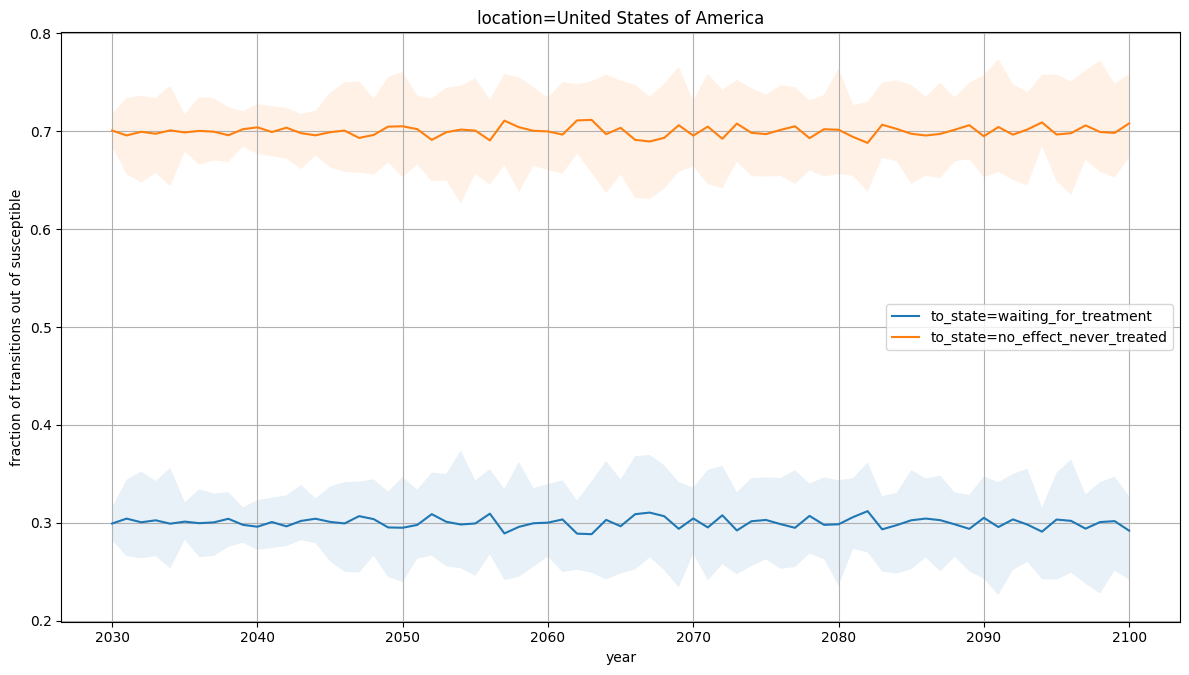

In [39]:
fig = plot_over_time_by_column_for_row_x_1(
    initiate_vs_not,
    'to_state',
    'location',
    ylabel='fraction of transitions out of susceptible',
)
for ax in fig.axes:
    # Looks like this is unnecessary after converting year to int
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)

# Check #2 (completes vs. discontinues treatment)

10% of transitions to Full treatment effect status are by simulants who
discontinue treatment

## Looks good

In [40]:
treatment_transitions.from_state.unique()

['waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'susceptible_to_treatment']
Categories (6, object): ['full_effect_long', 'full_effect_short', 'susceptible_to_treatment', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [41]:
# This gives the fraction of the total transitions out of
# 'waiting_for_treatment' that go to 'full_effect_long' vs.
# 'full_effect_short'. These ratios should be 0.9 and 0.1, respectively,
# across locations, age groups, draws, etc.
complete_vs_discontinue = ops.ratio(
    treatment_transitions,
    treatment_transitions,
    strata=[],
    prefilter_query="from_state == 'waiting_for_treatment'",
    numerator_broadcast=['to_state'],
    # denominator_broadcast=['to_state'],
)
complete_vs_discontinue

input_draw                    scenario                  location  \
0            2  bbbm_testing_and_treatment  United States of America   
1            2  bbbm_testing_and_treatment  United States of America   
2           13  bbbm_testing_and_treatment  United States of America   
3           13  bbbm_testing_and_treatment  United States of America   
4           24  bbbm_testing_and_treatment  United States of America   
5           24  bbbm_testing_and_treatment  United States of America   
6           41  bbbm_testing_and_treatment  United States of America   
7           41  bbbm_testing_and_treatment  United States of America   
8           46  bbbm_testing_and_treatment  United States of America   
9           46  bbbm_testing_and_treatment  United States of America   
10          89  bbbm_testing_and_treatment  United States of America   
11          89  bbbm_testing_and_treatment  United States of America   
12         113  bbbm_testing_and_treatment  United States of America   
13         113  bbbm_testing_and_treatment  United States of America   
14         158  bbbm_testing_and_treatment  United States of America   
15         158  bbbm_testing_and_treatment  United States of America   
16         169  bbbm_testing_and_treatment  United States of America   
17         169  bbbm_testing_and_treatment  United States of America   
18         177  bbbm_testing_and_treatment  United States of America   
19         177  bbbm_testing_and_treatment  United States of America   
20         199  bbbm_testing_and_treatment  United States of America   
21         199  bbbm_testing_and_treatment  United States of America   
22         258  bbbm_testing_and_treatment  United States of America   
23         258  bbbm_testing_and_treatment  United States of America   
24         262  bbbm_testing_and_treatment  United States of America   
25         262  bbbm_testing_and_treatment  United States of America   
26         265  bbbm_testing_and_treatment  United States of America   
27         265  bbbm_testing_and_treatment  United States of America   
28         273  bbbm_testing_and_treatment  United States of America   
29         273  bbbm_testing_and_treatment  United States of America   
30         317  bbbm_testing_and_treatment  United States of America   
31         317  bbbm_testing_and_treatment  United States of America   
32         323  bbbm_testing_and_treatment  United States of America   
33         323  bbbm_testing_and_treatment  United States of America   
34         346  bbbm_testing_and_treatment  United States of America   
35         346  bbbm_testing_and_treatment  United States of America   
36         356  bbbm_testing_and_treatment  United States of America   
37         356  bbbm_testing_and_treatment  United States of America   
38         392  bbbm_testing_and_treatment  United States of America   
39         392  bbbm_testing_and_treatment  United States of America   
40         446  bbbm_testing_and_treatment  United States of America   
41         446  bbbm_testing_and_treatment  United States of America   
42         457  bbbm_testing_and_treatment  United States of America   
43         457  bbbm_testing_and_treatment  United States of America   
44         460  bbbm_testing_and_treatment  United States of America   
45         460  bbbm_testing_and_treatment  United States of America   
46         480  bbbm_testing_and_treatment  United States of America   
47         480  bbbm_testing_and_treatment  United States of America   
48         499  bbbm_testing_and_treatment  United States of America   
49         499  bbbm_testing_and_treatment  United States of America   

             to_state     value numerator_measure denominator_measure  \
0    full_effect_long  0.900436  transition_count    transition_count   
1   full_effect_short  0.099564  transition_count    transition_count   
2    full_effect_long  0.899045  transition_count    transition_count   
3   full_effect_short  0.100955  transi

In [42]:
# Draw 2 in Japan: ratio of fraction of transitions to full_effect_long
# to fraction of transitions to full_effect short (rowss 0 and 1 above),
# gives the same value as the row for draw 2 in Japan in the table
# below:
# 8	2	bbbm_testing_and_treatment	Japan	8.956227	transition_count	transition_count	1
0.899560 / 0.100440

8.956192751891678

In [43]:
# This gives the ratio of the total transitions from start -> long to
# start -> short. The ratio should be approximately 9.0 for all
# locations, draws, age groups, etc. These ratios are equivalent to
# dividing the 'full_effect_long' rows in the previous dataframe by the
# 'full_effect_short' rows (see above cell for an example).
complete_to_discontinue_ratio = ops.ratio(
    treatment_transitions.query("to_state == 'full_effect_long'"),
    treatment_transitions.query("to_state == 'full_effect_short'"),
    strata=[],
    prefilter_query="from_state == 'waiting_for_treatment'",
    # numerator_broadcast=['to_state'],
    # denominator_broadcast=['to_state'],
)
complete_to_discontinue_ratio

input_draw                    scenario                  location     value  \
0         346  bbbm_testing_and_treatment  United States of America  8.819706   
1           2  bbbm_testing_and_treatment  United States of America  9.043746   
2         177  bbbm_testing_and_treatment  United States of America  8.866989   
3         113  bbbm_testing_and_treatment  United States of America  8.897538   
4         356  bbbm_testing_and_treatment  United States of America  9.048589   
5          13  bbbm_testing_and_treatment  United States of America  8.905378   
6          24  bbbm_testing_and_treatment  United States of America  9.090289   
7          89  bbbm_testing_and_treatment  United States of America  8.967523   
8         457  bbbm_testing_and_treatment  United States of America  9.051889   
9          46  bbbm_testing_and_treatment  United States of America  9.190846   
10        392  bbbm_testing_and_treatment  United States of America  8.772351   
11        499  bbbm_testing_and_treatment  United States of America  8.803453   
12         41  bbbm_testing_and_treatment  United States of America  8.913462   
13        258  bbbm_testing_and_treatment  United States of America  8.764375   
14        273  bbbm_testing_and_treatment  United States of America  8.929600   
15        262  bbbm_testing_and_treatment  United States of America  9.131369   
16        169  bbbm_testing_and_treatment  United States of America  8.822548   
17        446  bbbm_testing_and_treatment  United States of America  8.871729   
18        265  bbbm_testing_and_treatment  United States of America  9.276978   
19        460  bbbm_testing_and_treatment  United States of America  8.974966   
20        317  bbbm_testing_and_treatment  United States of America  9.078794   
21        480  bbbm_testing_and_treatment  United States of America  9.004779   
22        199  bbbm_testing_and_treatment  United States of America  8.947771   
23        323  bbbm_testing_and_treatment  United States of America  9.052511   
24        158  bbbm_testing_and_treatment  United States of America  9.121706   

   numerator_measure denominator_measure  multiplier  
0   transition_count    transition_count           1  
1   transition_count    transition_count           1  
2   transition_count    transition_count           1  
3   transition_count    transition_count           1  
4   transition_count    transition_count           1  
5   transition_count    transition_count           1  
6   transition_count    transition_count           1  
7   transition_count    transition_count           1  
8   transition_count    transition_count           1  
9   transition_count    transition_count           1  
10  transition_count    transition_count           1  
11  transition_count    transition_count           1  
12  transition_count    transition_count           1  
13  transition_count    transition_count           1  
14  transition_count    transition_count           1  
15  transition_count    transition_count           1  
16  transition_count    transition_count           1  
17  transition_count    transition_count           1  
18  transition_count    transition_count           1  
19  transition_count    transition_count           1  
20  transition_count    transition_count           1  
21  transition_count    transition_count           1  
22  transition_count    transition_count           1  
23  transition_count    transition_count           1  
24  transition_count    transition_count           1

In [44]:
summarize_sim_data(complete_to_discontinue_ratio)

count  \
denominator_measure location                 multiplier numerator_measure scenario                            
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment   25.0   

                                                                                                          mean  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment  8.973955   

                                                                                                           std  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment  0.134285   

                                                                                                           min  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment  8.764375   

                                                                                                         lower  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment  8.769161   

                                                                                                           50%  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment  8.967523   

                                                                                                         upper  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment  9.225299   

                                                                                                           max  
denominator_measure location                 multiplier numerator_measure scenario                              
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment  9.276978

In [45]:
summarize_sim_data(complete_vs_discontinue)

count  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                   
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long    25.0   
                                                                                                     full_effect_short   25.0   

                                                                                                                            mean  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.899721   
                                                                                                     full_effect_short  0.100279   

                                                                                                                             std  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.001345   
                                                                                                     full_effect_short  0.001345   

                                                                                                                             min  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.897587   
                                                                                                     full_effect_short  0.097305   

                                                                                                                           lower  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.897637   
                                                                                                     full_effect_short  0.097798   

                                                                                                                             50%  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.899674   
                                                                                                     full_effect_short  0.100326   

                                                                                                                           upper  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.902202   
                                                                                                     full_effect_short  0.102363   

                                                                                                                             max  
denominator_measure location                 multiplier numerator_measure scenario                   to_state                     
transition_count    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.902695  
                                    

# Check #3 (durations of full vs. waning treatment)

Full/Waning durations are accurate (use person-time ratios between
states?)

## Strategy

Look at ratio of person-time in each state to the person-time in the
`'waiting_for_treatment'` state. Using the fact that 90% of simulants complete
treatment and end up in the "long" states, while 10% of simulants
discontinue treatment and end up in the "short" states, we can predict
what these ratios should be.

## Results

Things look good except for the `'waning_effect_long'` state, whose
ratio to the `'waiting_for_treatment'` state looks too low (it's the same as
for the `'full_effect_long'` state).

In [46]:
all_tx_states = person_time_treatment.sub_entity.unique()
all_tx_states

['susceptible_to_treatment', 'waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']
Categories (9, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', ..., 'susceptible_to_treatment', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [47]:
no_effect_states = [state for state in all_tx_states if 'no_effect' in state]
no_effect_states

['no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']

In [48]:
# Compute ratio of person-time in each state to the person-time in the
# "waiting_for_treatment" state
tx_person_time_ratios = ops.ratio(
    person_time_treatment,
    person_time_treatment.query("sub_entity == 'waiting_for_treatment'"),
    strata=['event_year'],
    prefilter_query=(
        "scenario == 'bbbm_testing_and_treatment'"
        f" and event_year >= 2030" #" and age_group in {treatment_eligible_age_groups}"
        f" and sub_entity not in {no_effect_states + ['susceptible_to_treatment']}"
    ),
    numerator_broadcast=['sub_entity'],
)
tx_person_time_ratios

event_year  input_draw                    scenario  \
0           2030           2  bbbm_testing_and_treatment   
1           2030           2  bbbm_testing_and_treatment   
2           2030           2  bbbm_testing_and_treatment   
3           2030           2  bbbm_testing_and_treatment   
4           2030           2  bbbm_testing_and_treatment   
...          ...         ...                         ...   
8870        2100         499  bbbm_testing_and_treatment   
8871        2100         499  bbbm_testing_and_treatment   
8872        2100         499  bbbm_testing_and_treatment   
8873        2100         499  bbbm_testing_and_treatment   
8874        2100         499  bbbm_testing_and_treatment   

                      location             sub_entity      value  \
0     United States of America  waiting_for_treatment   1.000000   
1     United States of America       full_effect_long   0.000000   
2     United States of America      full_effect_short   0.000000   
3     United States of America     waning_effect_long   0.000000   
4     United States of America    waning_effect_short   0.000000   
...                        ...                    ...        ...   
8870  United States of America  waiting_for_treatment   1.000000   
8871  United States of America       full_effect_long   8.459034   
8872  United States of America      full_effect_short   0.105042   
8873  United States of America     waning_effect_long  10.627101   
8874  United States of America    waning_effect_short   0.564076   

     numerator_measure denominator_measure  multiplier  
0          person_time         person_time           1  
1          person_time         person_time           1  
2          person_time         person_time           1  
3          person_time         person_time           1  
4          person_time         person_time           1  
...                ...                 ...         ...  
8870       person_time         person_time           1  
8871       person_time         person_time           1  
8872       person_time         person_time           1  
8873       person_time         person_time           1  
8874       person_time         person_time           1  

[8875 rows x 9 columns]

In [49]:
tx_state_durations = pd.DataFrame(
    {
        # Durations from state diagram in treatment documentation
        'duration': [0.5, 5.0, 0.5, 9.0, 2.5],
        # 90% of people complete treatment and get long treatment
        # effect, 10% discontinue and get short treatment effect 
        'population_fraction': [1, 0.9, 0.1, 0.9, 0.1],
    },
    index=pd.CategoricalIndex(
        ['waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short'],
        name='sub_entity',
    )
)
# Compute the ratio of the population-weighted duration of each state to
# the duration of the "start treatment" state.
tx_state_durations['target_person_time_ratio'] = (
    tx_state_durations['duration'] * tx_state_durations['population_fraction']
    / tx_state_durations.at['waiting_for_treatment', 'duration']
)
tx_state_durations


duration  population_fraction  target_person_time_ratio
sub_entity                                                                    
waiting_for_treatment       0.5                  1.0                       1.0
full_effect_long            5.0                  0.9                       9.0
full_effect_short           0.5                  0.1                       0.1
waning_effect_long          9.0                  0.9                      16.2
waning_effect_short         2.5                  0.1                       0.5

In [50]:
# For posting in Slack...
print(tx_state_durations.rename(
    columns={'population_fraction': 'pop_frac', 'target_person_time_ratio': 'pt_ratio'}))

                       duration  pop_frac  pt_ratio
sub_entity                                         
waiting_for_treatment       0.5       1.0       1.0
full_effect_long            5.0       0.9       9.0
full_effect_short           0.5       0.1       0.1
waning_effect_long          9.0       0.9      16.2
waning_effect_short         2.5       0.1       0.5


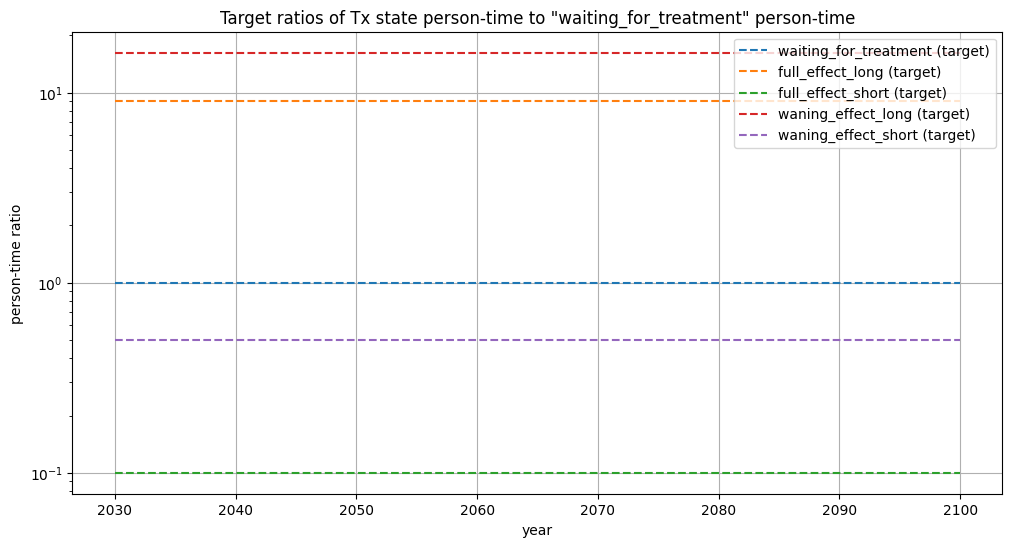

In [51]:
def plot_treatment_state_targets(tx_state_durations, column, ax):
    """Plot horizontal lines for values in one column of the treatment
    state durations table.
    """
    existing_lines = ax.get_lines()
    if len(existing_lines) == 0:
        # Axes.hlines plots all lines in a single color by default, so if you
        # want different colors, you have to explicitly cycle through them 
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']

    for i, state in enumerate(tx_state_durations.index):
        # Find color corresponding to state if there already exists a
        # line for that state
        for line in existing_lines:
            if state in line.get_label():
                color = line.get_color()
                break
        # If there were no existing lines, go to next color in cycle
        if len(existing_lines) == 0:
            color = colors[i % len(colors)]
        ax.hlines(tx_state_durations.at[state, column], 2030, 2100, color, '--', label=f'{state} (target)')
    return ax

fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'target_person_time_ratio', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target ratios of Tx state person-time to "waiting_for_treatment" person-time',
)
ax.grid(True)
ax.legend()
ax.semilogy()
plt.show()

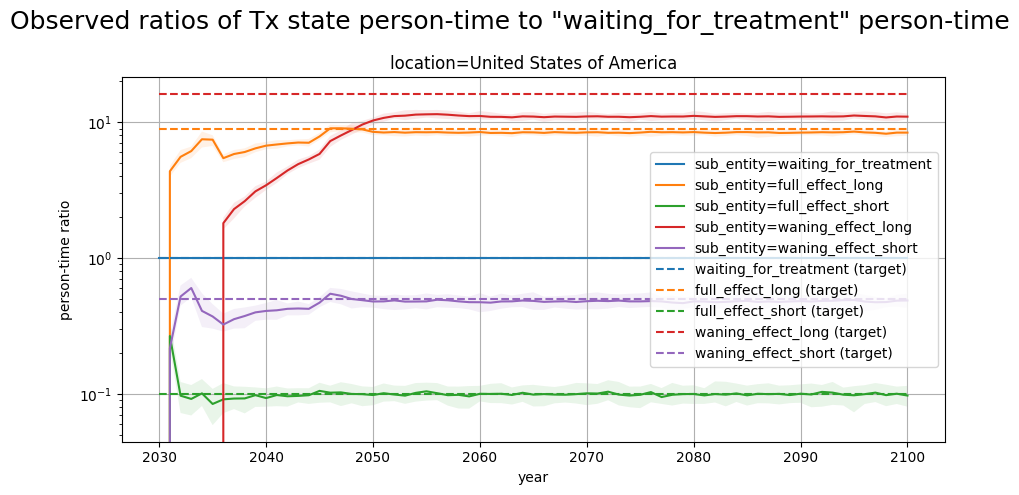

In [52]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_person_time_ratios,
    'sub_entity',
    'location',
    ylabel='person-time ratio',
    suptitle='Observed ratios of Tx state person-time to "waiting_for_treatment" person-time',
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'target_person_time_ratio', ax)
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
    ax.legend()
    ax.semilogy()
plt.show()

## Check values

In [53]:
tx_person_time_ratios.query("sub_entity == 'waning_effect_long' and event_year>2060").value.describe()

count    1000.000000
mean       11.027912
std         0.409888
min         9.845632
25%        10.740205
50%        11.015831
75%        11.315894
max        12.306609
Name: value, dtype: float64

In [54]:
tx_person_time_ratios.query("sub_entity == 'full_effect_long' and event_year>2060").value.describe()

count    1000.000000
mean        8.411561
std         0.272525
min         7.435967
25%         8.233882
50%         8.419625
75%         8.587435
max         9.217155
Name: value, dtype: float64

In [55]:
# Compute implied durations from the ratios above
# Target durations are (9, 5)
12.576105 / .9 * .5, 8.641488 / .9 * .5

(6.986725, 4.800826666666667)

## Look at actual person-time instead of the ratio

In [56]:
ops.describe(
    ops.stratify(
        person_time_treatment.query(
            "value > 0 and "
            "(sub_entity == 'waiting_for_treatment' or "
            " sub_entity.str.endswith('effect_long')) and event_year > 2060"
            " and location == 'Spain'"
        ),
        ['event_year', 'sub_entity']
    )
)

Empty DataFrame
Columns: [count, mean, std, min, 2.5%, 50%, 97.5%, max]
Index: []

In [57]:
9721.296427 / 1129.481287

8.606868071998433

In [58]:
13995.099904 / 1129.481287

12.390731980316554

# Check #4 (duration of start treatment/waiting for treatment)

“In treatment/waiting for treatment” duration is accurate (use
person-time ratios between states?)

This duration is supposed to be 6 months for all simulants.

## Strategy

To compute the average duration of each state, divide the total
person-time of that state by the number of simulants entering that
state, i.e., the the sum of transition counts where it's the `to_state`.

Alternatively, compute the average duration by dividing the total
person-time by the number of simulants *exiting* the state, i.e., the
sum of transition counts where it's the `from_state`.

## Results

I'm not sure how closely either of these strategies should match the
actual duration... Neither takes deaths into account, and I stratified
the calculations by year, which seems weird because some of the
durations are much longer than a year.

Nevertheless, the observed average durations for 4 out of 5 of the
states eventually converge to a value pretty close to the specified
duration, using either of the above two methods. The fifth state,
`'waning_effect_long'`, converges to different values in each of the
above two methods, neither of which is particularly close to the target
duration of 9 years. We think this is probably due to mortality.

In [59]:
person_time_treatment

age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
1025995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1025996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1025997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1025998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1025999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw      measure  \
0        treatment       cause        2025        346  person_time   
1        treatment       cause        2025        346  person_time   
2        treatment       cause        2025        346  person_time   
3        treatment       cause        2025        346  person_time   
4        treatment       cause        2025        346  person_time   
...            ...         ...         ...        ...          ...   
1025995  treatment       cause        2100        158  person_time   
1025996  treatment       cause        2100        158  person_time   
1025997  treatment       cause        2100        158  person_time   
1025998  treatment       cause        2100        158  person_time   
1025999  treatment       cause        2100        158  person_time   

                           scenario     sex                sub_entity  \
0                          baseline  Female  susceptible_to_treatment   
1                          baseline  Female     waiting_for_treatment   
2                          baseline  Female          full_effect_long   
3                          baseline  Female         full_effect_short   
4                          baseline  Female        waning_effect_long   
...                             ...     ...                       ...   
1025995  bbbm_testing_and_treatment    Male        waning_effect_long   
1025996  bbbm_testing_and_treatment    Male       waning_effect_short   
1025997  bbbm_testing_and_treatment    Male      no_effect_after_long   
1025998  bbbm_testing_and_treatment    Male     no_effect_after_short   
1025999  bbbm_testing_and_treatment    Male   no_effect_never_treated   

              value                  location  
0          0.000000  United States of America  
1          0.000000  United States of America  
2          0.000000  United States of America  
3          0.000000  United States of America  
4          0.000000  United States of America  
...             ...                       ...  
1025995    0.000000  United States of America  
1025996    0.000000  United States of America  
1025997  100.156057  United States of America  
1025998    5.481177  United States of America  
1025999  206.789870  United States of America  

[1026000 rows x 12 columns]

In [60]:
treatment_transitions.query("value>0")

age_group                                      artifact_path  \
214800  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
214801  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
214806  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
214807  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
214808  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
425564  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   
425572  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   
425580  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   
425588  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   
425596  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   

           entity entity_type event_year input_draw                  location  \
214800  treatment       cause       2030        346  United States of America   
214801  treatment       cause       2030        346  United States of America   
214806  treatment       cause       2030        346  United States of America   
214807  treatment       cause       2030        346  United States of America   
214808  treatment       cause       2030        346  United States of America   
...           ...         ...        ...        ...                       ...   
425564  treatment       cause       2100        199  United States of America   
425572  treatment       cause       2100        323  United States of America   
425580  treatment       cause       2100        323  United States of America   
425588  treatment       cause       2100        158  United States of America   
425596  treatment       cause       2100        158  United States of America   

                 measure                    scenario     sex  \
214800  transition_count  bbbm_testing_and_treatment  Female   
214801  transition_count  bbbm_testing_and_treatment  Female   
214806  transition_count  bbbm_testing_and_treatment  Female   
214807  transition_count  bbbm_testing_and_treatment  Female   
214808  transition_count  bbbm_testing_and_treatment    Male   
...                  ...                         ...     ...   
425564  transition_count  bbbm_testing_and_treatment    Male   
425572  transition_count  bbbm_testing_and_treatment  Female   
425580  transition_count  bbbm_testing_and_treatment    Male   
425588  transition_count  bbbm_testing_and_treatment  Female   
425596  transition_count  bbbm_testing_and_treatment    Male   

                                               sub_entity  value  \
214800          waiting_for_treatment_to_full_effect_long   29.0   
214801         waiting_for_treatment_to_full_effect_short    4.0   
214806  susceptible_to_treatment_to_waiting_for_treatment   37.0   
214807  susceptible_to_treatment_to_no_effect_never_tr...  107.0   
214808          waiting_for_treatment_to_full_effect_long   22.0   
...                                                   ...    ...   
425564         waning_effect_long_to_no_effect_after_long   27.0   
425572         waning_effect_long_to_no_effect_after_long   38.0   
425580         waning_effect_long_to_no_effect_after_long   22.0   
425588         waning_effect_long_to_no_effect_after_long   54.0   
425596         waning_effect_long_to_no_effect_after_long   28.0   

                      from_state                 to_state  
214800     waiting_for_treatment         full_effect_long  
214801     waiting_for_treatment        full_effect_short  
214806  susceptible_to_treatment    waiting_for_treatment  
214807  susceptible_to_treatment  no_effect_never_treated  
214808     waiting_for_treatment         full_effect_long  
...                          ...                      ...  
425564        waning_effect_long     no_effect_after_long  
425572        waning_effect_long     no_effect_after_long  
425580        waning_effect_long     no_effect_after_lo

In [61]:
tx_state_mean_durations_incoming = ops.ratio(
    person_time_treatment.assign(to_state=lambda df: df['sub_entity']),
    treatment_transitions.query("value>0"),
    strata=['event_year', 'to_state'],
    prefilter_query=(
        "scenario=='bbbm_testing_and_treatment' and event_year >= 2030"
    )
)
tx_state_mean_durations_incoming

event_year             to_state  input_draw  \
0            2030     full_effect_long           2   
1            2030     full_effect_long          13   
2            2030     full_effect_long          24   
3            2030     full_effect_long          41   
4            2030     full_effect_long          46   
...           ...                  ...         ...   
15970        2100  waning_effect_short         446   
15971        2100  waning_effect_short         457   
15972        2100  waning_effect_short         460   
15973        2100  waning_effect_short         480   
15974        2100  waning_effect_short         499   

                         scenario                  location     value  \
0      bbbm_testing_and_treatment  United States of America  0.000000   
1      bbbm_testing_and_treatment  United States of America  0.000000   
2      bbbm_testing_and_treatment  United States of America  0.000000   
3      bbbm_testing_and_treatment  United States of America  0.000000   
4      bbbm_testing_and_treatment  United States of America  0.000000   
...                           ...                       ...       ...   
15970  bbbm_testing_and_treatment  United States of America  2.578773   
15971  bbbm_testing_and_treatment  United States of America  2.480612   
15972  bbbm_testing_and_treatment  United States of America  2.547951   
15973  bbbm_testing_and_treatment  United States of America  2.983262   
15974  bbbm_testing_and_treatment  United States of America  2.675811   

      numerator_measure denominator_measure  multiplier  
0           person_time    transition_count           1  
1           person_time    transition_count           1  
2           person_time    transition_count           1  
3           person_time    transition_count           1  
4           person_time    transition_count           1  
...                 ...                 ...         ...  
15970       person_time    transition_count           1  
15971       person_time    transition_count           1  
15972       person_time    transition_count           1  
15973       person_time    transition_count           1  
15974       person_time    transition_count           1  

[15975 rows x 9 columns]

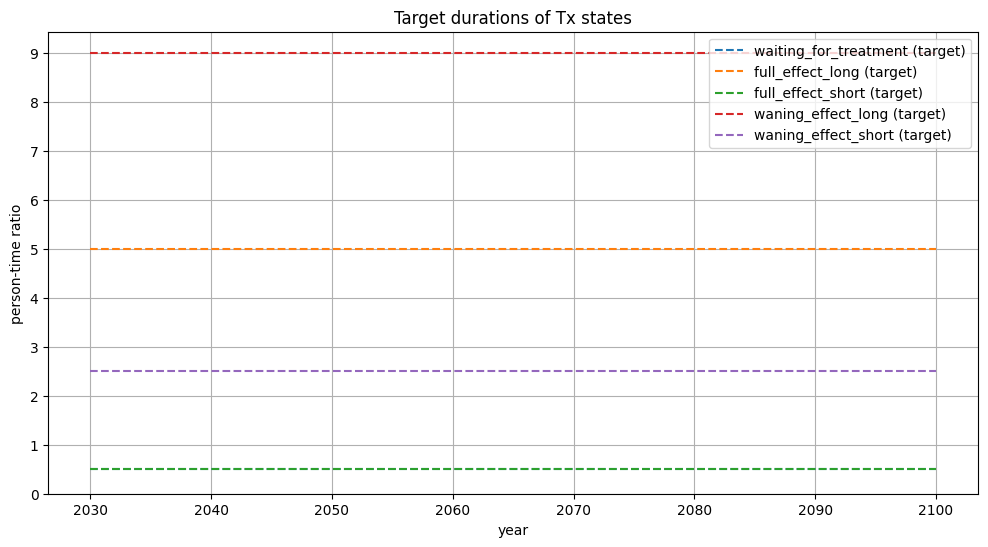

In [62]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target durations of Tx states',
)
ax.grid(True)
ax.legend()
ax.set(yticks=range(0,10))
# ax.semilogy()
plt.show()

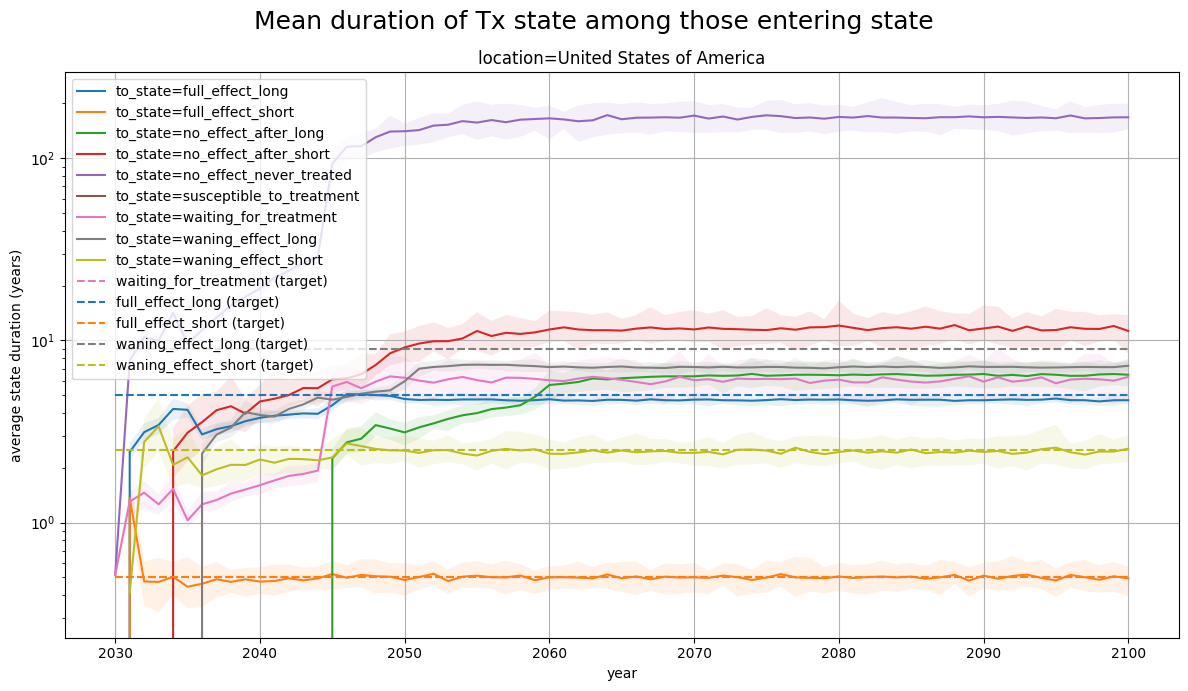

In [63]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_state_mean_durations_incoming,
    'to_state',
    'location',
    ylabel='average state duration (years)',
    suptitle="Mean duration of Tx state among those entering state",
    # axes_width=9,
    # axes_height=4,
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
    ax.legend()
    ax.grid(True)
    ax.semilogy()
plt.show()

In [64]:
tx_state_mean_durations_outgoing = ops.ratio(
    person_time_treatment.assign(from_state=lambda df: df['sub_entity']),
    treatment_transitions.query("value>0"),
    strata=['event_year', 'from_state'],
    prefilter_query=(
        "scenario=='bbbm_testing_and_treatment' and event_year >= 2030"
    )
)
tx_state_mean_durations_outgoing

event_year           from_state  input_draw  \
0            2030     full_effect_long           2   
1            2030     full_effect_long          13   
2            2030     full_effect_long          24   
3            2030     full_effect_long          41   
4            2030     full_effect_long          46   
...           ...                  ...         ...   
15970        2100  waning_effect_short         446   
15971        2100  waning_effect_short         457   
15972        2100  waning_effect_short         460   
15973        2100  waning_effect_short         480   
15974        2100  waning_effect_short         499   

                         scenario                  location     value  \
0      bbbm_testing_and_treatment  United States of America       NaN   
1      bbbm_testing_and_treatment  United States of America       NaN   
2      bbbm_testing_and_treatment  United States of America       NaN   
3      bbbm_testing_and_treatment  United States of America       NaN   
4      bbbm_testing_and_treatment  United States of America       NaN   
...                           ...                       ...       ...   
15970  bbbm_testing_and_treatment  United States of America  2.842511   
15971  bbbm_testing_and_treatment  United States of America  2.328738   
15972  bbbm_testing_and_treatment  United States of America  2.601592   
15973  bbbm_testing_and_treatment  United States of America  2.801356   
15974  bbbm_testing_and_treatment  United States of America  2.758568   

      numerator_measure denominator_measure  multiplier  
0           person_time    transition_count           1  
1           person_time    transition_count           1  
2           person_time    transition_count           1  
3           person_time    transition_count           1  
4           person_time    transition_count           1  
...                 ...                 ...         ...  
15970       person_time    transition_count           1  
15971       person_time    transition_count           1  
15972       person_time    transition_count           1  
15973       person_time    transition_count           1  
15974       person_time    transition_count           1  

[15975 rows x 9 columns]

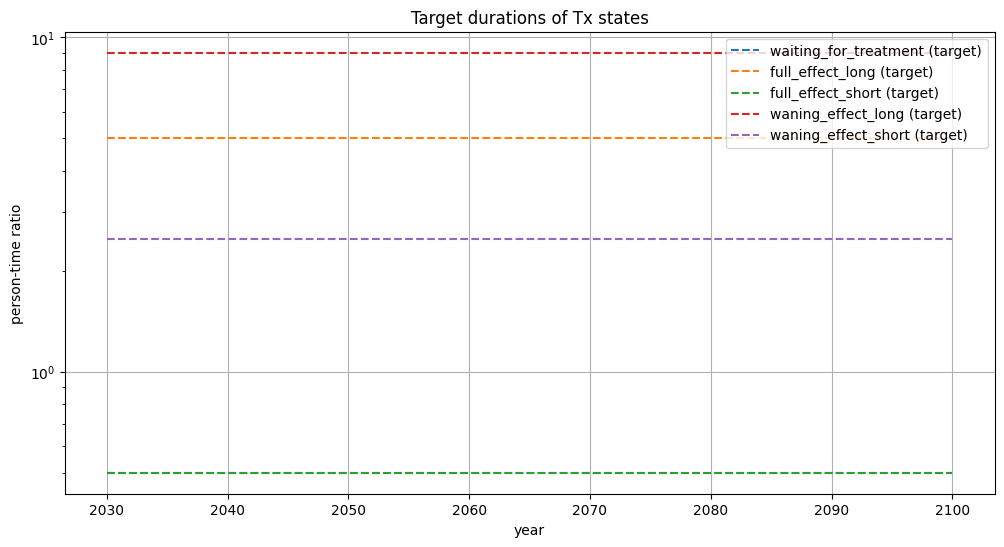

In [65]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target durations of Tx states',
)
ax.grid(True)
ax.legend()
ax.set(yticks=range(0,10))
ax.semilogy()
plt.show()

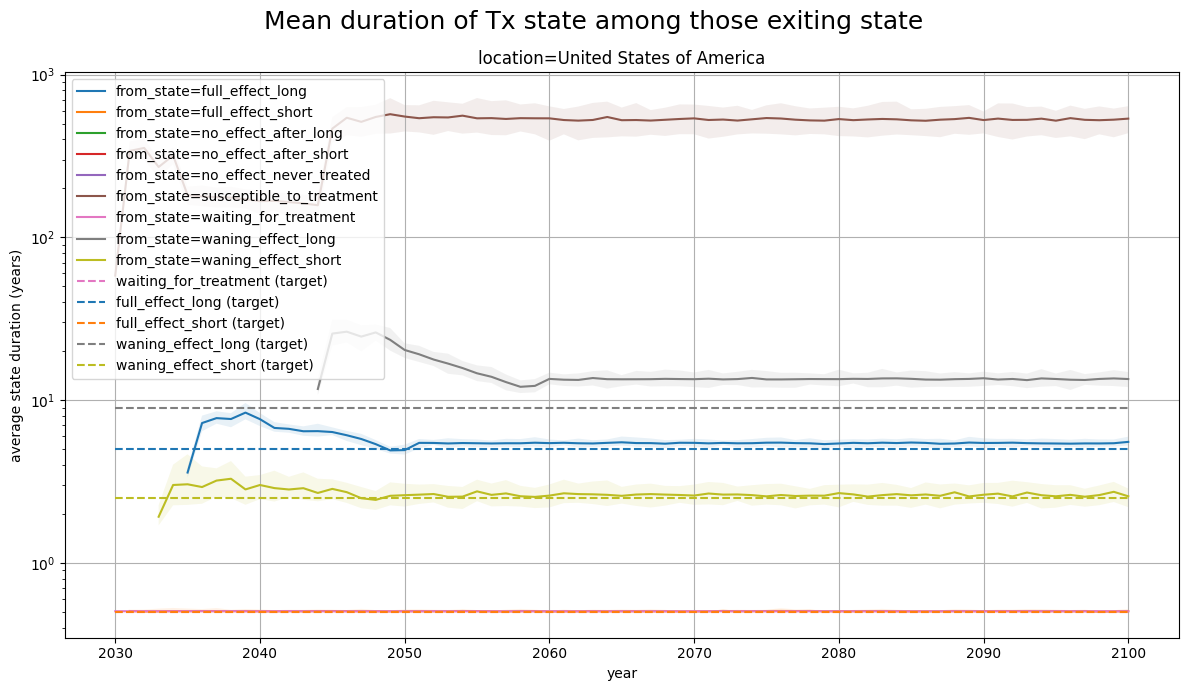

In [66]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_state_mean_durations_outgoing,
    'from_state',
    'location',
    ylabel='average state duration (years)',
    suptitle="Mean duration of Tx state among those exiting state",
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
    ax.legend()
    ax.grid(True)
    ax.semilogy()
plt.show()

## Check value of `waning_effect_long`

It's not close to 9 years in either graph.

In [67]:
tx_state_mean_durations_incoming.query("to_state == 'waning_effect_long' and event_year > 2060").value.describe()

count    1000.000000
mean        7.133975
std         0.273700
min         6.335470
25%         6.938529
50%         7.140291
75%         7.310270
max         8.280450
Name: value, dtype: float64

In [68]:
tx_state_mean_durations_outgoing.query("from_state == 'waning_effect_long' and event_year > 2060").value.describe()

count    1000.000000
mean       13.460603
std         0.811214
min        11.245358
25%        12.897425
50%        13.429833
75%        13.967210
max        16.470816
Name: value, dtype: float64

## By contrast, check the value of `full_effect_long`

It **is** close to 5 years in _both_ graphs.

In [69]:
tx_state_mean_durations_incoming.query("to_state == 'full_effect_long' and event_year > 2060").value.describe()

count    1000.000000
mean        4.706996
std         0.162046
min         4.116540
25%         4.603040
50%         4.703518
75%         4.817369
max         5.215289
Name: value, dtype: float64

In [70]:
tx_state_mean_durations_outgoing.query("from_state == 'full_effect_long' and event_year > 2060").value.describe()

count    1000.000000
mean        5.441309
std         0.179980
min         4.962303
25%         5.317759
50%         5.425233
75%         5.564708
max         6.132436
Name: value, dtype: float64

# Check #5 (Interactive sim)

I'm planning to do the interactive sim in another notebook.

# Check #6 (hazard ratio)

Check hazard ratios for simulants who begin treatment and those who
transition to *No treatment effect* (Check hazard ratio of treated to
not treated for hazard rate from BBBM to MCI)

## I think I can't check this in the outputs because neither cause transitions nor cause state person-time is stratified by treatment status

In [71]:
person_time_cause_states = load_sim_output(
    'person_time_alzheimers_disease_and_other_dementias'
)
print_memory_usage(person_time_cause_states)
person_time_cause_states

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf'])
64.644149 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
3077995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3077996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3077997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3077998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3077999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
0        alzheimers_disease_and_other_dementias       cause        2025   
1        alzheimers_disease_and_other_dementias       cause        2025   
2        alzheimers_disease_and_other_dementias       cause        2025   
3        alzheimers_disease_and_other_dementias       cause        2025   
4        alzheimers_disease_and_other_dementias       cause        2025   
...                                         ...         ...         ...   
3077995  alzheimers_disease_and_other_dementias       cause        2100   
3077996  alzheimers_disease_and_other_dementias       cause        2100   
3077997  alzheimers_disease_and_other_dementias       cause        2100   
3077998  alzheimers_disease_and_other_dementias       cause        2100   
3077999  alzheimers_disease_and_other_dementias       cause        2100   

        input_draw      measure                    scenario     sex  \
0              346  person_time                    baseline  Female   
1              346  person_time                    baseline  Female   
2              346  person_time                    baseline  Female   
3              346  person_time                    baseline  Female   
4              346  person_time                    baseline  Female   
...            ...          ...                         ...     ...   
3077995        158  person_time  bbbm_testing_and_treatment    Male   
3077996        158  person_time  bbbm_testing_and_treatment    Male   
3077997        158  person_time  bbbm_testing_and_treatment    Male   
3077998        158  person_time  bbbm_testing_and_treatment    Male   
3077999        158  person_time  bbbm_testing_and_treatment    Male   

                                     sub_entity                 treatment  \
0        alzheimers_blood_based_biomarker_state  susceptible_to_treatment   
1        alzheimers_blood_based_biomarker_state     waiting_for_treatment   
2        alzheimers_blood_based_biomarker_state          full_effect_long   
3        alzheimers_blood_based_biomarker_state         full_effect_short   
4        alzheimers_blood_based_biomarker_state        waning_effect_long   
...                                         ...                       ...   
3077995                alzheimers_disease_state        waning_effect_long   
3077996                alzheimers_disease_state       waning_effect_short   
3077997                alzheimers_disease_state      no_effect_after_long   
3077998                alzheimers_disease_state     no_effect_after_short   
3077999                alzheimers_disease_state   no_effect_never_treated   

              value                  location  
0          0.000000  United States of America  
1          0.000000  United States of America  
2          0.000000  United States of America  
3          0.000000  United States of America  
4          0.000000  United States of America  
...             ...                       ...  
3077995    0.000000  United States of America  
3077996    0.000000  United States of America  
3077997   80.224504  United Stat

In [72]:
person_time_cause_states.dtypes

age_group        category
artifact_path    category
entity           category
entity_type      category
event_year          int16
input_draw       category
measure          category
scenario         category
sex              category
sub_entity       category
treatment        category
value             float64
location         category
dtype: object

In [73]:
person_time_cause_states.treatment.unique()

['susceptible_to_treatment', 'waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']
Categories (9, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', ..., 'susceptible_to_treatment', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [74]:
person_time_cause_states.sub_entity.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state', 'alzheimers_disease_state']
Categories (3, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_disease_state', 'alzheimers_mild_cognitive_impairment_state']

In [75]:
transition_count_cause_states = (
    load_sim_output(
        'transition_count_alzheimers_disease_and_other_dementias'
    )
    # Display memory usage of loaded dataframe before adding columns
    .pipe(lambda df: print_memory_usage(df) or df)
    # Add columns for from and to state
    .pipe(lambda df: df.join(
        cleaning.extract_transition_states(df, 'sub_entity'))
    )
    # Display memory usage of loaded dataframe after adding columns
    .pipe(lambda df: print_memory_usage(df) or df)
    # Convert the new columns to Categoricals
    .pipe(convert_to_categorical)
)
print_memory_usage(transition_count_cause_states)
transition_count_cause_states

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf'])
43.098147 MB
426.822147 MB
45.153449 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
2051995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2051996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2051997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2051998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2051999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type event_year  \
0        alzheimers_disease_and_other_dementias       cause       2025   
1        alzheimers_disease_and_other_dementias       cause       2025   
2        alzheimers_disease_and_other_dementias       cause       2025   
3        alzheimers_disease_and_other_dementias       cause       2025   
4        alzheimers_disease_and_other_dementias       cause       2025   
...                                         ...         ...        ...   
2051995  alzheimers_disease_and_other_dementias       cause       2100   
2051996  alzheimers_disease_and_other_dementias       cause       2100   
2051997  alzheimers_disease_and_other_dementias       cause       2100   
2051998  alzheimers_disease_and_other_dementias       cause       2100   
2051999  alzheimers_disease_and_other_dementias       cause       2100   

        input_draw           measure                    scenario     sex  \
0              346  transition_count                    baseline  Female   
1              346  transition_count                    baseline  Female   
2              346  transition_count                    baseline  Female   
3              346  transition_count                    baseline  Female   
4              346  transition_count                    baseline  Female   
...            ...               ...                         ...     ...   
2051995        158  transition_count  bbbm_testing_and_treatment    Male   
2051996        158  transition_count  bbbm_testing_and_treatment    Male   
2051997        158  transition_count  bbbm_testing_and_treatment    Male   
2051998        158  transition_count  bbbm_testing_and_treatment    Male   
2051999        158  transition_count  bbbm_testing_and_treatment    Male   

                                                sub_entity  \
0        alzheimers_blood_based_biomarker_state_to_alzh...   
1        alzheimers_blood_based_biomarker_state_to_alzh...   
2        alzheimers_blood_based_biomarker_state_to_alzh...   
3        alzheimers_blood_based_biomarker_state_to_alzh...   
4        alzheimers_blood_based_biomarker_state_to_alzh...   
...                                                    ...   
2051995  alzheimers_mild_cognitive_impairment_state_to_...   
2051996  alzheimers_mild_cognitive_impairment_state_to_...   
2051997  alzheimers_mild_cognitive_impairment_state_to_...   
2051998  alzheimers_mild_cognitive_impairment_state_to_...   
2051999  alzheimers_mild_cognitive_impairment_state_to_...   

                        treatment  value                  location  \
0        susceptible_to_treatment    0.0  United States of America   
1           waiting_for_treatment    0.0  United States of America   
2                full_effect_long    0.0  United States of America   
3               full_effect_short    0.0  United States of America   
4              waning_effect_long    0.0  United States of America   
...                           ...    ...                       ...   
2051995        waning_effect_long    0.0  United States of America   
2051996       waning_effect_short   

In [76]:
transition_count_cause_states.from_state.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state']
Categories (2, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state']

In [77]:
incidence_rates_by_treatment = ops.ratio(
    transition_count_cause_states,
    person_time_cause_states.rename(columns={'sub_entity': 'from_state'}),
    strata=['event_year', 'from_state', 'treatment'],
    numerator_broadcast='to_state', # Shouldn't actually broadcast, just record it
    measure='transition_rate',
    dropna=True,
)
incidence_rates_by_treatment

event_year                                  from_state  \
0            2025      alzheimers_blood_based_biomarker_state   
1            2025      alzheimers_blood_based_biomarker_state   
2            2025      alzheimers_blood_based_biomarker_state   
3            2025      alzheimers_blood_based_biomarker_state   
4            2025      alzheimers_blood_based_biomarker_state   
...           ...                                         ...   
32976        2100  alzheimers_mild_cognitive_impairment_state   
32977        2100  alzheimers_mild_cognitive_impairment_state   
32978        2100  alzheimers_mild_cognitive_impairment_state   
32979        2100  alzheimers_mild_cognitive_impairment_state   
32980        2100  alzheimers_mild_cognitive_impairment_state   

                      treatment  input_draw                    scenario  \
0      susceptible_to_treatment           2                    baseline   
1      susceptible_to_treatment           2  bbbm_testing_and_treatment   
2      susceptible_to_treatment          13                    baseline   
3      susceptible_to_treatment          13  bbbm_testing_and_treatment   
4      susceptible_to_treatment          24                    baseline   
...                         ...         ...                         ...   
32976       waning_effect_short         446  bbbm_testing_and_treatment   
32977       waning_effect_short         457  bbbm_testing_and_treatment   
32978       waning_effect_short         460  bbbm_testing_and_treatment   
32979       waning_effect_short         480  bbbm_testing_and_treatment   
32980       waning_effect_short         499  bbbm_testing_and_treatment   

                       location                                    to_state  \
0      United States of America  alzheimers_mild_cognitive_impairment_state   
1      United States of America  alzheimers_mild_cognitive_impairment_state   
2      United States of America  alzheimers_mild_cognitive_impairment_state   
3      United States of America  alzheimers_mild_cognitive_impairment_state   
4      United States of America  alzheimers_mild_cognitive_impairment_state   
...                         ...                                         ...   
32976  United States of America                    alzheimers_disease_state   
32977  United States of America                    alzheimers_disease_state   
32978  United States of America                    alzheimers_disease_state   
32979  United States of America                    alzheimers_disease_state   
32980  United States of America                    alzheimers_disease_state   

          value          measure numerator_measure denominator_measure  \
0      0.143847  transition_rate  transition_count         person_time   
1      0.143847  transition_rate  transition_count         person_time   
2      0.144130  transition_rate  transition_count         person_time   
3      0.144130  transition_rate  transition_count         person_time   
4      0.141644  transition_rate  transition_count         person_time   
...         ...              ...               ...                 ...   
32976  0.123881  transition_rate  transition_count         person_time   
32977  0.071674  transition_rate  transition_count         person_time   
32978  0.152420  transition_rate  transition_count         person_time   
32979  0.154374  transition_rate  transition_count         person_time   
32980  0.179720  transition_rate  transition_count         person_time   

       multiplier  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
32976           1  
32977           1  
32978           1  
32979           1  
32980           1  

[32981 rows x 12 columns]

## Investigate infinite transition rates between disease states

My plotting code below initially failed with `FloatingPointError:
invalid value encountered in subtract` in the `lower` function, due to
infinities in the transition rates data.

According to the engineers, we may be getting 0 person-time in some
strata where counts are nonzero because person-time is recorded at the
beginning of a time step, while transition counts are recorded at the
end. So for example, if someone starts in preclinical, in the "waiting
for treatment" state, then transitions to MCI and to "full effect long"
on the same time step, then they would have their person-time recorded
in the (preclinical, waiting for treatment) stratum, but their disease
transition recorded in the (preclinical- > MCI, full effect long)
stratum.

The engineers said there was a bugfix in model 7.2 that *might* address
this problem, so I'll try this again there...

In [78]:
incidence_rates_by_treatment.value.describe()

count    3.298100e+04
mean              inf
std               NaN
min      0.000000e+00
25%      1.249989e-01
50%      1.687035e-01
75%      2.517324e-01
max               inf
Name: value, dtype: float64

In [79]:
inf = np.isinf(incidence_rates_by_treatment.value)
print(inf.sum(), "rows with infinite values")
incidence_rates_by_treatment.loc[inf]#.query("from_state=='alzheimers_blood_based_biomarker_state'")

195 rows with infinite values


event_year                                  from_state  \
500         2030      alzheimers_blood_based_biomarker_state   
501         2030      alzheimers_blood_based_biomarker_state   
502         2030      alzheimers_blood_based_biomarker_state   
503         2030      alzheimers_blood_based_biomarker_state   
504         2030      alzheimers_blood_based_biomarker_state   
...          ...                                         ...   
6229        2044  alzheimers_mild_cognitive_impairment_state   
6230        2044  alzheimers_mild_cognitive_impairment_state   
6231        2044  alzheimers_mild_cognitive_impairment_state   
6232        2044  alzheimers_mild_cognitive_impairment_state   
6233        2044  alzheimers_mild_cognitive_impairment_state   

                 treatment  input_draw                    scenario  \
500       full_effect_long           2  bbbm_testing_and_treatment   
501       full_effect_long          13  bbbm_testing_and_treatment   
502       full_effect_long          24  bbbm_testing_and_treatment   
503       full_effect_long          41  bbbm_testing_and_treatment   
504       full_effect_long          46  bbbm_testing_and_treatment   
...                    ...         ...                         ...   
6229  no_effect_after_long         446  bbbm_testing_and_treatment   
6230  no_effect_after_long         457  bbbm_testing_and_treatment   
6231  no_effect_after_long         460  bbbm_testing_and_treatment   
6232  no_effect_after_long         480  bbbm_testing_and_treatment   
6233  no_effect_after_long         499  bbbm_testing_and_treatment   

                      location                                    to_state  \
500   United States of America  alzheimers_mild_cognitive_impairment_state   
501   United States of America  alzheimers_mild_cognitive_impairment_state   
502   United States of America  alzheimers_mild_cognitive_impairment_state   
503   United States of America  alzheimers_mild_cognitive_impairment_state   
504   United States of America  alzheimers_mild_cognitive_impairment_state   
...                        ...                                         ...   
6229  United States of America                    alzheimers_disease_state   
6230  United States of America                    alzheimers_disease_state   
6231  United States of America                    alzheimers_disease_state   
6232  United States of America                    alzheimers_disease_state   
6233  United States of America                    alzheimers_disease_state   

      value          measure numerator_measure denominator_measure  multiplier  
500     inf  transition_rate  transition_count         person_time           1  
501     inf  transition_rate  transition_count         person_time           1  
502     inf  transition_rate  transition_count         person_time           1  
503     inf  transition_rate  transition_count         person_time           1  
504     inf  transition_rate  transition_count         person_time           1  
...     ...              ...               ...                 ...         ...  
6229    inf  transition_rate  transition_count         person_time           1  
6230    inf  transition_rate  transition_count         person_time           1  
6231    inf  transition_rate  transition_count         person_time           1  
6232    inf  transition_rate  transition_count         person_time           1  
6233    inf  transition_rate  transition_count         person_time           1  

[195 rows x 12 columns]

In [80]:
transition_count_cause_states.query(
    "scenario=='bbbm_testing_and_treatment'"
    " and event_year==2044 and from_state=='alzheimers_blood_based_biomarker_state'"
    " and input_draw==499 and treatment=='full_effect_long'"
    " and age_group in @treatment_eligible_age_groups"
)

age_group                                      artifact_path  \
992630   60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
992648   60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
1129430  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
1129448  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
1266230  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
1266248  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
1403030  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
1403048  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
1539830  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   
1539848  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type event_year  \
992630   alzheimers_disease_and_other_dementias       cause       2044   
992648   alzheimers_disease_and_other_dementias       cause       2044   
1129430  alzheimers_disease_and_other_dementias       cause       2044   
1129448  alzheimers_disease_and_other_dementias       cause       2044   
1266230  alzheimers_disease_and_other_dementias       cause       2044   
1266248  alzheimers_disease_and_other_dementias       cause       2044   
1403030  alzheimers_disease_and_other_dementias       cause       2044   
1403048  alzheimers_disease_and_other_dementias       cause       2044   
1539830  alzheimers_disease_and_other_dementias       cause       2044   
1539848  alzheimers_disease_and_other_dementias       cause       2044   

        input_draw           measure                    scenario     sex  \
992630         499  transition_count  bbbm_testing_and_treatment  Female   
992648         499  transition_count  bbbm_testing_and_treatment    Male   
1129430        499  transition_count  bbbm_testing_and_treatment  Female   
1129448        499  transition_count  bbbm_testing_and_treatment    Male   
1266230        499  transition_count  bbbm_testing_and_treatment  Female   
1266248        499  transition_count  bbbm_testing_and_treatment    Male   
1403030        499  transition_count  bbbm_testing_and_treatment  Female   
1403048        499  transition_count  bbbm_testing_and_treatment    Male   
1539830        499  transition_count  bbbm_testing_and_treatment  Female   
1539848        499  transition_count  bbbm_testing_and_treatment    Male   

                                                sub_entity         treatment  \
992630   alzheimers_blood_based_biomarker_state_to_alzh...  full_effect_long   
992648   alzheimers_blood_based_biomarker_state_to_alzh...  full_effect_long   
1129430  alzheimers_blood_based_biomarker_state_to_alzh...  full_effect_long   
1129448  alzheimers_blood_based_biomarker_state_to_alzh...  full_effect_long   
1266230  alzheimers_blood_based_biomarker_state_to_alzh...  full_effect_long   
1266248  alzheimers_blood_based_biomarker_state_to_alzh...  full_effect_long   
1403030  alzheimers_blood_based_biomarker_state_to_alzh...  full_effect_long   
1403048  alzheimers_blood_based_biomarker_state_to_alzh...  full_effect_long   
1539830  alzheimers_blood_based_biomarker_state_to_alzh...  full_effect_long   
1539848  alzheimers_blood_based_biomarker_state_to_alzh...  full_effect_long   

         value                  location  \
992630    14.0  United States of America   
992648    10.0  United States of America   
1129430   32.0  United States of America   
1129448    9.0  United States of America   
1266230   36.0  United States of America   
1266248   26.0  United States of America   
1403030   40.0  United States of America   
1403048   31.0  United States of America   
1539830   28.0  United States of America   
1539848   12.0  United States of America   

                                     from_state  \
992630   alzheimers_blood_based_biomarker_state   
992648   alzheimers_blood_based_biomarker_state   
1129430  alzheimers_blood_based_biomarker_st

In [81]:
person_time_cause_states.query(
    "scenario=='bbbm_testing_and_treatment'"
    " and event_year==2030 and sub_entity=='alzheimers_blood_based_biomarker_state'"
    " and input_draw==2 and treatment=='full_effect_long'"
    " and age_group in @treatment_eligible_age_groups"
)

age_group                                      artifact_path  \
1450064  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
1450091  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
1655264  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
1655291  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
1860464  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
1860491  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
2065664  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
2065691  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
2270864  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   
2270891  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
1450064  alzheimers_disease_and_other_dementias       cause        2030   
1450091  alzheimers_disease_and_other_dementias       cause        2030   
1655264  alzheimers_disease_and_other_dementias       cause        2030   
1655291  alzheimers_disease_and_other_dementias       cause        2030   
1860464  alzheimers_disease_and_other_dementias       cause        2030   
1860491  alzheimers_disease_and_other_dementias       cause        2030   
2065664  alzheimers_disease_and_other_dementias       cause        2030   
2065691  alzheimers_disease_and_other_dementias       cause        2030   
2270864  alzheimers_disease_and_other_dementias       cause        2030   
2270891  alzheimers_disease_and_other_dementias       cause        2030   

        input_draw      measure                    scenario     sex  \
1450064          2  person_time  bbbm_testing_and_treatment  Female   
1450091          2  person_time  bbbm_testing_and_treatment    Male   
1655264          2  person_time  bbbm_testing_and_treatment  Female   
1655291          2  person_time  bbbm_testing_and_treatment    Male   
1860464          2  person_time  bbbm_testing_and_treatment  Female   
1860491          2  person_time  bbbm_testing_and_treatment    Male   
2065664          2  person_time  bbbm_testing_and_treatment  Female   
2065691          2  person_time  bbbm_testing_and_treatment    Male   
2270864          2  person_time  bbbm_testing_and_treatment  Female   
2270891          2  person_time  bbbm_testing_and_treatment    Male   

                                     sub_entity         treatment  value  \
1450064  alzheimers_blood_based_biomarker_state  full_effect_long    0.0   
1450091  alzheimers_blood_based_biomarker_state  full_effect_long    0.0   
1655264  alzheimers_blood_based_biomarker_state  full_effect_long    0.0   
1655291  alzheimers_blood_based_biomarker_state  full_effect_long    0.0   
1860464  alzheimers_blood_based_biomarker_state  full_effect_long    0.0   
1860491  alzheimers_blood_based_biomarker_state  full_effect_long    0.0   
2065664  alzheimers_blood_based_biomarker_state  full_effect_long    0.0   
2065691  alzheimers_blood_based_biomarker_state  full_effect_long    0.0   
2270864  alzheimers_blood_based_biomarker_state  full_effect_long    0.0   
2270891  alzheimers_blood_based_biomarker_state  full_effect_long    0.0   

                         location  
1450064  United States of America  
1450091  United States of America  
1655264  United States of America  
1655291  United States of America  
1860464  United States of America  
1860491  United States of America  
2065664  United States of America  
2065691  United States of America  
2270864  United States of America  
2270891  United States of America

## Plot disease transition rates stratified by treatment status, filtering out $\infty$

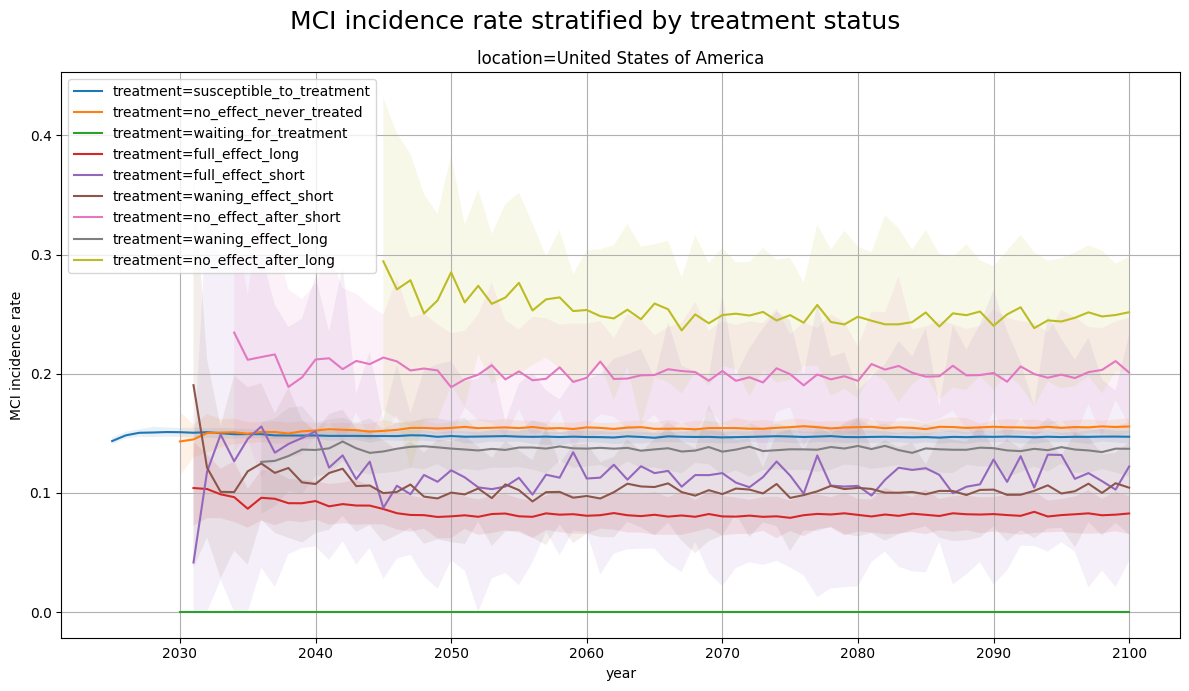

In [82]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    incidence_rates_by_treatment.loc[~inf].query("from_state=='alzheimers_blood_based_biomarker_state'"),
    'treatment',
    'location',
    ylabel='MCI incidence rate',
    suptitle='MCI incidence rate stratified by treatment status',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

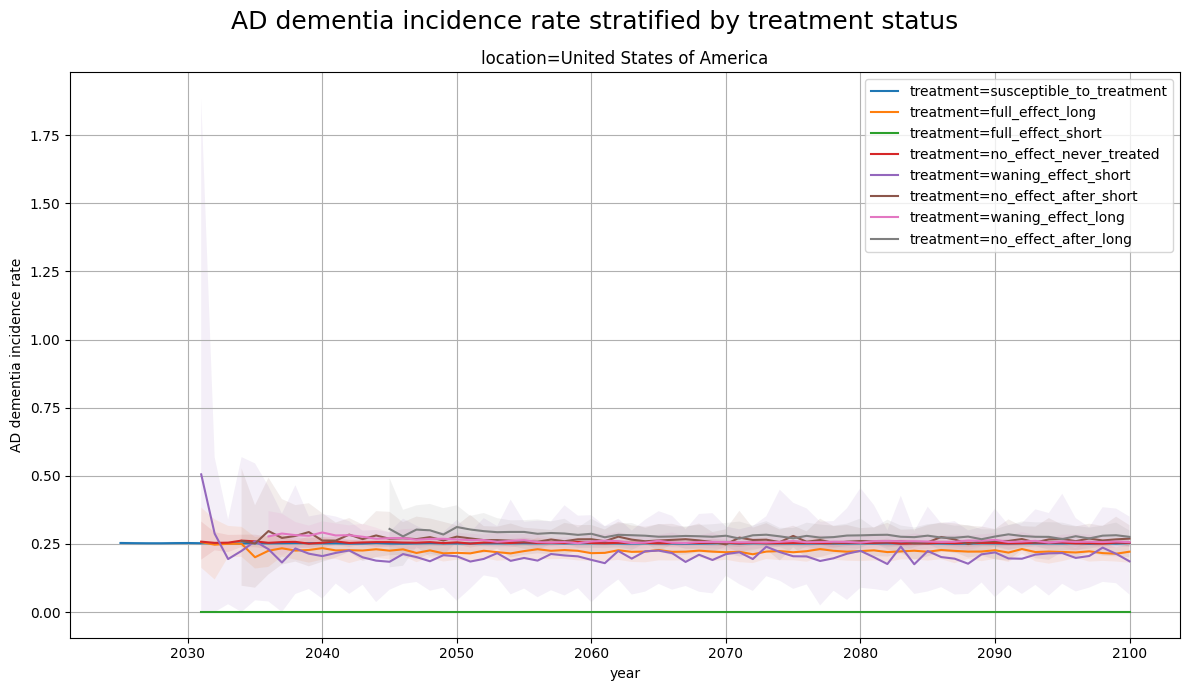

In [83]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    incidence_rates_by_treatment.loc[~inf].query("from_state=='alzheimers_mild_cognitive_impairment_state'"),
    'treatment',
    'location',
    ylabel='AD dementia incidence rate',
    suptitle='AD dementia incidence rate stratified by treatment status',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

## Compute hazard ratio

In [84]:
hazard_ratio = ops.ratio(
    incidence_rates_by_treatment,
    incidence_rates_by_treatment.query("treatment=='susceptible_to_treatment'"),
    strata=['event_year', 'from_state'],
    numerator_broadcast=['treatment'],
    # prefilter_query="from_state=='alzheimers_blood_based_biomarker_state'",
)
hazard_ratio

event_year                                  from_state  input_draw  \
0            2025      alzheimers_blood_based_biomarker_state           2   
1            2025      alzheimers_blood_based_biomarker_state           2   
2            2025      alzheimers_blood_based_biomarker_state          13   
3            2025      alzheimers_blood_based_biomarker_state          13   
4            2025      alzheimers_blood_based_biomarker_state          24   
...           ...                                         ...         ...   
32976        2100  alzheimers_mild_cognitive_impairment_state         499   
32977        2100  alzheimers_mild_cognitive_impairment_state         499   
32978        2100  alzheimers_mild_cognitive_impairment_state         499   
32979        2100  alzheimers_mild_cognitive_impairment_state         499   
32980        2100  alzheimers_mild_cognitive_impairment_state         499   

                         scenario                  location  \
0                        baseline  United States of America   
1      bbbm_testing_and_treatment  United States of America   
2                        baseline  United States of America   
3      bbbm_testing_and_treatment  United States of America   
4                        baseline  United States of America   
...                           ...                       ...   
32976  bbbm_testing_and_treatment  United States of America   
32977  bbbm_testing_and_treatment  United States of America   
32978  bbbm_testing_and_treatment  United States of America   
32979  bbbm_testing_and_treatment  United States of America   
32980  bbbm_testing_and_treatment  United States of America   

                      treatment     value numerator_measure  \
0      susceptible_to_treatment  1.000000   transition_rate   
1      susceptible_to_treatment  1.000000   transition_rate   
2      susceptible_to_treatment  1.000000   transition_rate   
3      susceptible_to_treatment  1.000000   transition_rate   
4      susceptible_to_treatment  1.000000   transition_rate   
...                         ...       ...               ...   
32976     no_effect_after_short  1.303323   transition_rate   
32977   no_effect_never_treated  1.001631   transition_rate   
32978  susceptible_to_treatment  1.000000   transition_rate   
32979        waning_effect_long  1.045809   transition_rate   
32980       waning_effect_short  0.706869   transition_rate   

      denominator_measure  multiplier  
0         transition_rate           1  
1         transition_rate           1  
2         transition_rate           1  
3         transition_rate           1  
4         transition_rate           1  
...                   ...         ...  
32976     transition_rate           1  
32977     transition_rate           1  
32978     transition_rate           1  
32979     transition_rate           1  
32980     transition_rate           1  

[32981 rows x 10 columns]

In [85]:
hazard_ratio.value.describe()

count    3.298100e+04
mean              inf
std               NaN
min      0.000000e+00
25%      7.614286e-01
50%      1.000000e+00
75%      1.044281e+00
max               inf
Name: value, dtype: float64

In [86]:
inf_ratio = np.isinf(hazard_ratio.value)
print(inf_ratio.sum(), "rows with infinite values")

195 rows with infinite values


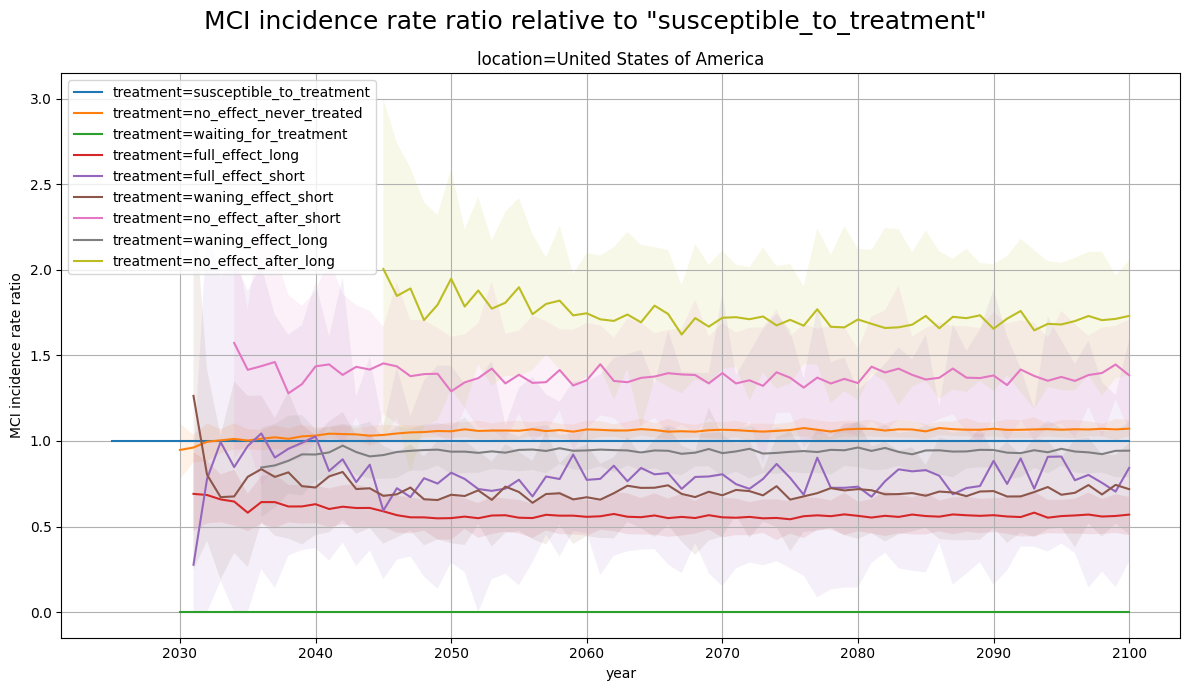

In [87]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    hazard_ratio.loc[~inf_ratio].query(
        "scenario=='bbbm_testing_and_treatment'"# and event_year > 2035"
        " and from_state=='alzheimers_blood_based_biomarker_state'"
        ),
    'treatment',
    'location',
    ylabel='MCI incidence rate ratio',
    suptitle='MCI incidence rate ratio relative to "susceptible_to_treatment"',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

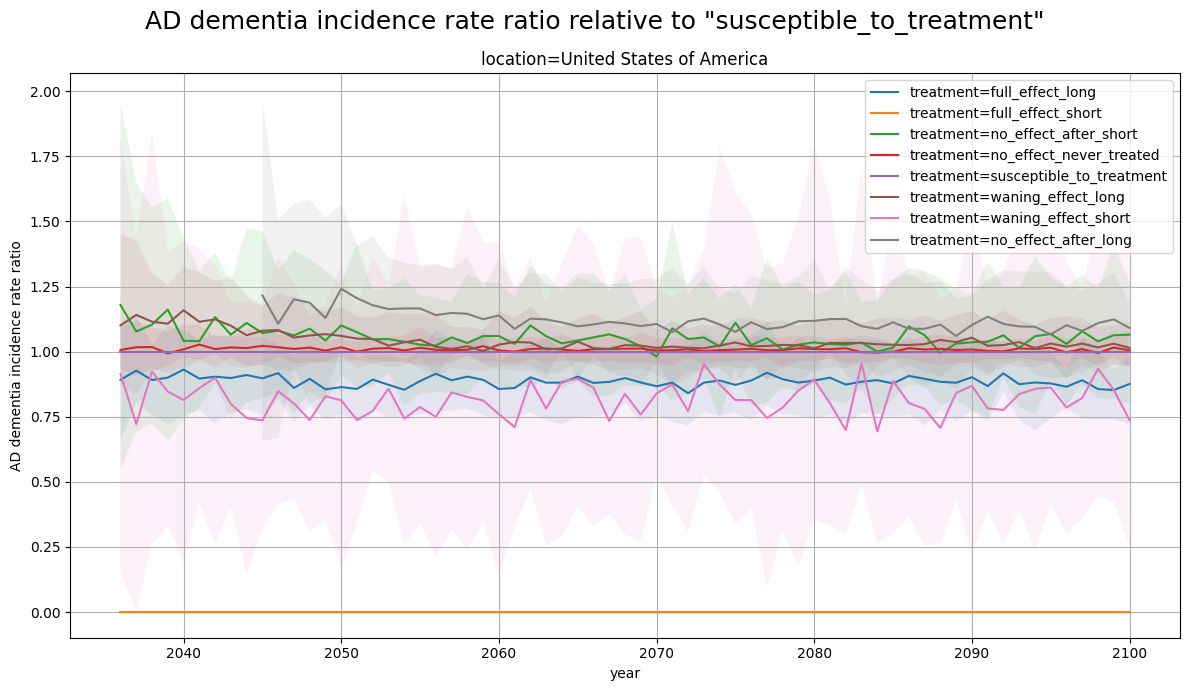

In [88]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    hazard_ratio.loc[~inf_ratio].query(
        "scenario=='bbbm_testing_and_treatment' and event_year > 2035"
        " and from_state=='alzheimers_mild_cognitive_impairment_state'"
        ),
    'treatment',
    'location',
    ylabel='AD dementia incidence rate ratio',
    suptitle='AD dementia incidence rate ratio relative to "susceptible_to_treatment"',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

# Results!

# Load deaths and plot averted deaths by scenario

In [89]:
deaths = load_sim_output('deaths')
print_memory_usage(deaths)
deaths

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf'])
4.336824 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
227995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
227996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
227997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
227998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
227999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                          entity entity_type  event_year input_draw measure  \
0       alzheimers_disease_state       cause        2025        346  deaths   
1       alzheimers_disease_state       cause        2025        346  deaths   
2       alzheimers_disease_state       cause        2025        346  deaths   
3       alzheimers_disease_state       cause        2025        346  deaths   
4       alzheimers_disease_state       cause        2025          2  deaths   
...                          ...         ...         ...        ...     ...   
227995              other_causes       cause        2100        323  deaths   
227996              other_causes       cause        2100        158  deaths   
227997              other_causes       cause        2100        158  deaths   
227998              other_causes       cause        2100        158  deaths   
227999              other_causes       cause        2100        158  deaths   

                          scenario     sex   value                  location  
0                         baseline  Female     0.0  United States of America  
1                         baseline    Male     0.0  United States of America  
2       bbbm_testing_and_treatment  Female     0.0  United States of America  
3       bbbm_testing_and_treatment    Male     0.0  United States of America  
4                         baseline  Female     0.0  United States of America  
...                            ...     ...     ...                       ...  
227995  bbbm_testing_and_treatment    Male   912.0  United States of America  
227996                    baseline  Female  1731.0  United States of America  
227997                    baseline    Male   769.0  United States of America  
227998  bbbm_testing_and_treatment  Female  1736.0  United States of America  
227999  bbbm_testing_and_treatment    Male   772.0  United States of America  

[228000 rows x 11 columns]

In [90]:
# NOTE: I had to rework some code in my vph_output.operators.difference
# function to prevent this code from converting Categoricals back to
# strings and making the memory explode...
averted_deaths = ops.averted(deaths, baseline_scenario='baseline')
print_memory_usage(averted_deaths)
# convert_dtypes(averted_deaths, colname_to_dtype=colname_to_categorical_dtype, inplace=True)
# print_memory_usage(averted_deaths)
# convert_to_categorical(averted_deaths, inplace=True)
# print_memory_usage(averted_deaths)
averted_deaths

4.336824 MB measure
3.082692 MB minuend
3.082692 MB subtrahend
2.059979 MB minuend re-indexed
2.059979 MB subtrahend re-indexed
2.060039 MB difference
2.854824 MB difference with reset index
2.969149 MB final difference
2.969149 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
113995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
113996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
113997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
113998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
113999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                          entity entity_type  event_year input_draw measure  \
0       alzheimers_disease_state       cause        2025        346  deaths   
1       alzheimers_disease_state       cause        2025        346  deaths   
2       alzheimers_disease_state       cause        2025          2  deaths   
3       alzheimers_disease_state       cause        2025          2  deaths   
4       alzheimers_disease_state       cause        2025        177  deaths   
...                          ...         ...         ...        ...     ...   
113995              other_causes       cause        2100        199  deaths   
113996              other_causes       cause        2100        323  deaths   
113997              other_causes       cause        2100        323  deaths   
113998              other_causes       cause        2100        158  deaths   
113999              other_causes       cause        2100        158  deaths   

           sex                  location                    scenario  \
0       Female  United States of America  bbbm_testing_and_treatment   
1         Male  United States of America  bbbm_testing_and_treatment   
2       Female  United States of America  bbbm_testing_and_treatment   
3         Male  United States of America  bbbm_testing_and_treatment   
4       Female  United States of America  bbbm_testing_and_treatment   
...        ...                       ...                         ...   
113995    Male  United States of America  bbbm_testing_and_treatment   
113996  Female  United States of America  bbbm_testing_and_treatment   
113997    Male  United States of America  bbbm_testing_and_treatment   
113998  Female  United States of America  bbbm_testing_and_treatment   
113999    Male  United States of America  bbbm_testing_and_treatment   

       subtracted_from  value  
0             baseline    0.0  
1             baseline    0.0  
2             baseline    0.0  
3             baseline    0.0  
4             baseline    0.0  
...                ...    ...  
113995        baseline   -4.0  
113996        baseline   -1.0  
113997        baseline   -3.0  
113998        baseline   -5.0  
113999        baseline   -3.0  

[114000 rows x 12 columns]

In [91]:
averted_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   age_group        114000 non-null  category
 1   artifact_path    114000 non-null  category
 2   entity           114000 non-null  category
 3   entity_type      114000 non-null  category
 4   event_year       114000 non-null  int64   
 5   input_draw       114000 non-null  category
 6   measure          114000 non-null  category
 7   sex              114000 non-null  category
 8   location         114000 non-null  category
 9   scenario         114000 non-null  category
 10  subtracted_from  114000 non-null  category
 11  value            114000 non-null  float64 
dtypes: category(10), float64(1), int64(1)
memory usage: 2.8 MB


In [92]:
averted_deaths['scenario'].dtype.categories

Index(['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment'], dtype='object')

In [93]:
averted_deaths.index.memory_usage(deep=True)

132

In [94]:
averted_deaths.entity.unique()

['alzheimers_disease_state', 'other_causes']
Categories (2, object): ['alzheimers_disease_state', 'other_causes']

In [95]:
averted_deaths.value.describe()

count    114000.000000
mean          0.071175
std           2.591144
min         -38.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          29.000000
Name: value, dtype: float64

In [96]:
# convert_dtypes(averted_deaths, colname_to_categorical_dtype, inplace=True)
# convert_to_categorical(averted_deaths, inplace=True)
print_memory_usage(averted_deaths)

2.969149 MB


In [97]:
# FIXME: Wait, to get percent deaths averted, do I want to be dividing
# by deaths in the intervention scenarios (like I do here), or should I
# be dividing by deaths in the *baseline* scenario? Probably the
# latter...
print_memory_usage(averted_deaths)
averted_deaths_pct = ops.ratio(
    averted_deaths,
    deaths.query("scenario != 'baseline'"),
    strata=['entity', 'age_group', 'event_year'],
    dropna=True, # Drop strata in younger age groups where we divided by 0
    multiplier=100,
)
print_memory_usage(averted_deaths_pct)
# convert_dtypes(averted_deaths_pct, colname_to_categorical_dtype, inplace=True)
# print_memory_usage(averted_deaths_pct)
# convert_to_categorical(averted_deaths_pct, inplace=True)
# print_memory_usage(averted_deaths_pct)
averted_deaths_pct

2.969149 MB
1.273364 MB


entity age_group  event_year input_draw  \
0      alzheimers_disease_state  40_to_44        2027        199   
1      alzheimers_disease_state  40_to_44        2029        177   
2      alzheimers_disease_state  40_to_44        2029        392   
3      alzheimers_disease_state  40_to_44        2029        499   
4      alzheimers_disease_state  40_to_44        2029        265   
...                         ...       ...         ...        ...   
40932              other_causes   95_plus        2100        317   
40933              other_causes   95_plus        2100        480   
40934              other_causes   95_plus        2100        199   
40935              other_causes   95_plus        2100        323   
40936              other_causes   95_plus        2100        158   

                         scenario                  location     value  \
0      bbbm_testing_and_treatment  United States of America  0.000000   
1      bbbm_testing_and_treatment  United States of America  0.000000   
2      bbbm_testing_and_treatment  United States of America  0.000000   
3      bbbm_testing_and_treatment  United States of America  0.000000   
4      bbbm_testing_and_treatment  United States of America  0.000000   
...                           ...                       ...       ...   
40932  bbbm_testing_and_treatment  United States of America -0.648056   
40933  bbbm_testing_and_treatment  United States of America -0.103555   
40934  bbbm_testing_and_treatment  United States of America -0.486618   
40935  bbbm_testing_and_treatment  United States of America -0.141543   
40936  bbbm_testing_and_treatment  United States of America -0.318979   

      numerator_measure denominator_measure  multiplier  
0                deaths              deaths         100  
1                deaths              deaths         100  
2                deaths              deaths         100  
3                deaths              deaths         100  
4                deaths              deaths         100  
...                 ...                 ...         ...  
40932            deaths              deaths         100  
40933            deaths              deaths         100  
40934            deaths              deaths         100  
40935            deaths              deaths         100  
40936            deaths              deaths         100  

[40937 rows x 10 columns]

In [98]:
averted_deaths_pct.memory_usage(deep=True)

Index                     132
entity                  41195
age_group               42467
event_year             327496
input_draw              41693
scenario                41262
location                41911
value                  327496
numerator_measure       41108
denominator_measure     41108
multiplier             327496
dtype: int64

In [99]:
ops.stratify(averted_deaths, 'event_year')

event_year input_draw                    scenario  \
0           2025        346  bbbm_testing_and_treatment   
1           2025          2  bbbm_testing_and_treatment   
2           2025        177  bbbm_testing_and_treatment   
3           2025        113  bbbm_testing_and_treatment   
4           2025        356  bbbm_testing_and_treatment   
...          ...        ...                         ...   
1895        2100        317  bbbm_testing_and_treatment   
1896        2100        480  bbbm_testing_and_treatment   
1897        2100        199  bbbm_testing_and_treatment   
1898        2100        323  bbbm_testing_and_treatment   
1899        2100        158  bbbm_testing_and_treatment   

                      location  value  
0     United States of America    0.0  
1     United States of America    0.0  
2     United States of America    0.0  
3     United States of America    0.0  
4     United States of America    0.0  
...                        ...    ...  
1895  United States of America   -6.0  
1896  United States of America    4.0  
1897  United States of America   -4.0  
1898  United States of America    8.0  
1899  United States of America    4.0  

[1900 rows x 5 columns]

In [100]:
# # FIXME: For some reason, this was taking a long time (>30 seconds before I interrupted it)
# averted_deaths_summary = summarize_sim_data(averted_deaths)
# averted_deaths_summary

In [101]:
def f(a=None, *args, **kwargs):
    print(a, args, kwargs)

f(1,2,3)
f(2)
f(5, b=4)
f(5, 6, b=7)
f(a=5, b=7)
f()

1 (2, 3) {}
2 () {}
5 () {'b': 4}
5 (6,) {'b': 7}
5 () {'b': 7}
None () {}


In [102]:
f(2)

2 () {}


# Draw results plots

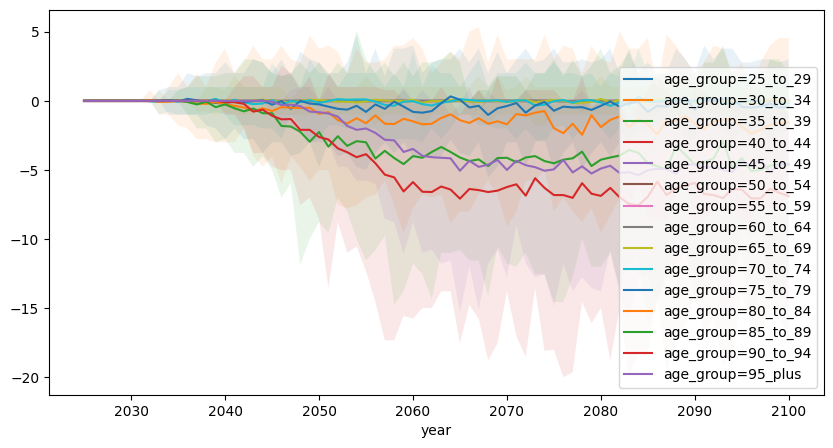

In [103]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(averted_deaths.query(
    "scenario == 'bbbm_testing_and_treatment' and entity == 'other_causes'"
    f" and location=={locations[0]!r}"
    ),
    'age_group'
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()


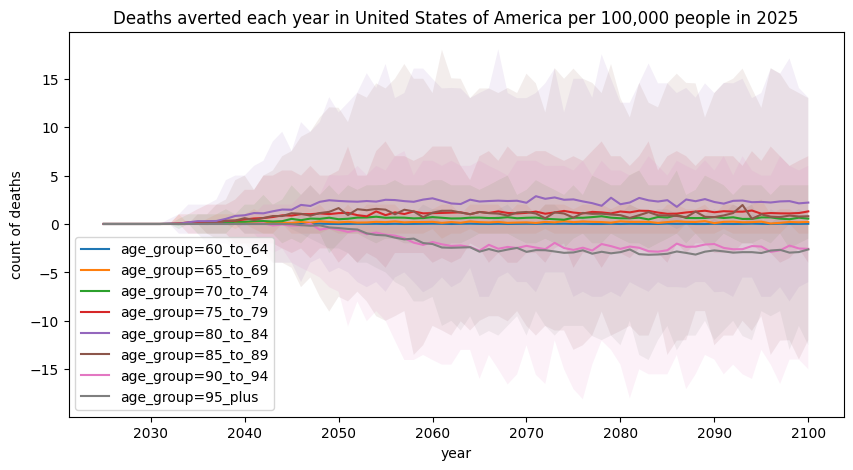

In [104]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment'" #and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="count of deaths",
    title=f"Deaths averted each year in {locations[0]} per 100,000 people in 2025"
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()

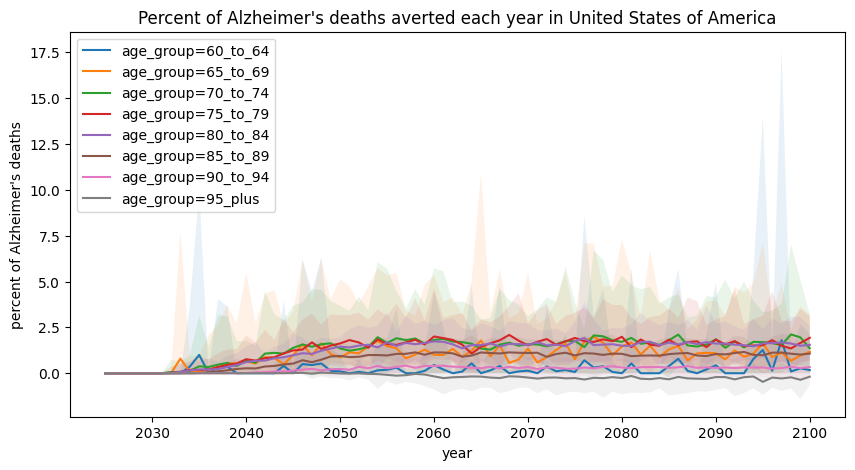

In [105]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_deaths_pct
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="percent of Alzheimer's deaths",
    title=f"Percent of Alzheimer's deaths averted each year in {locations[0]}"
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()

In [106]:
deaths.scenario.unique()

['baseline', 'bbbm_testing_and_treatment']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

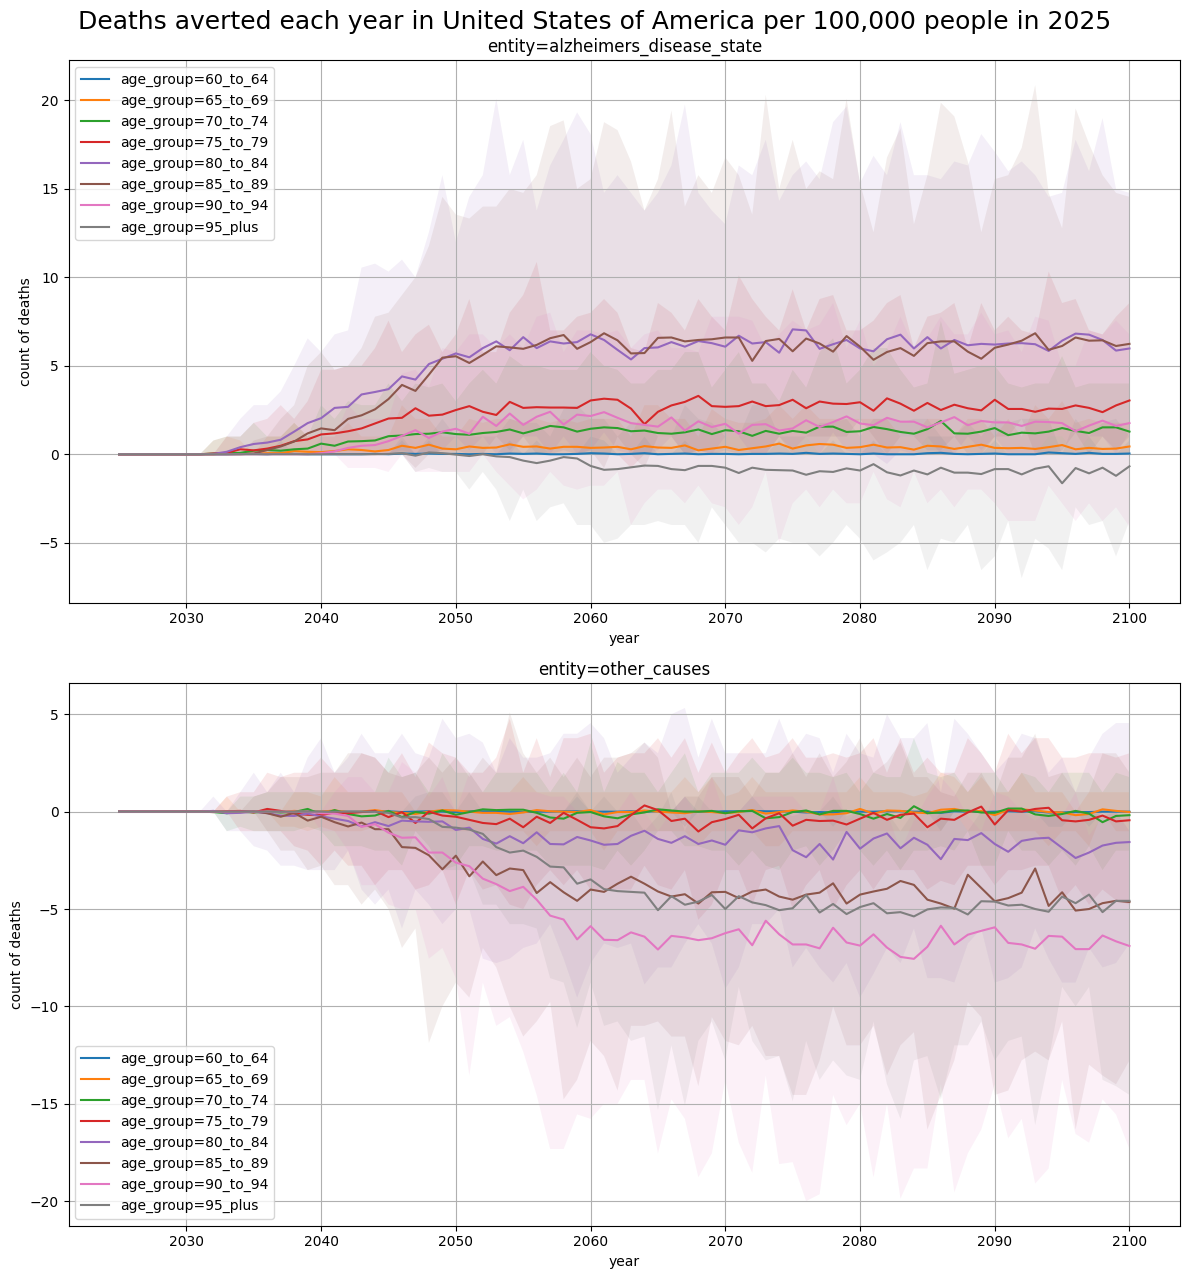

In [107]:
location = locations[0]
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and location==@location"
        ),
    'age_group',
    'entity',
    ylabel="count of deaths",
    suptitle=f"Deaths averted each year in {location} per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Absolute reductions in AD deaths for all countries

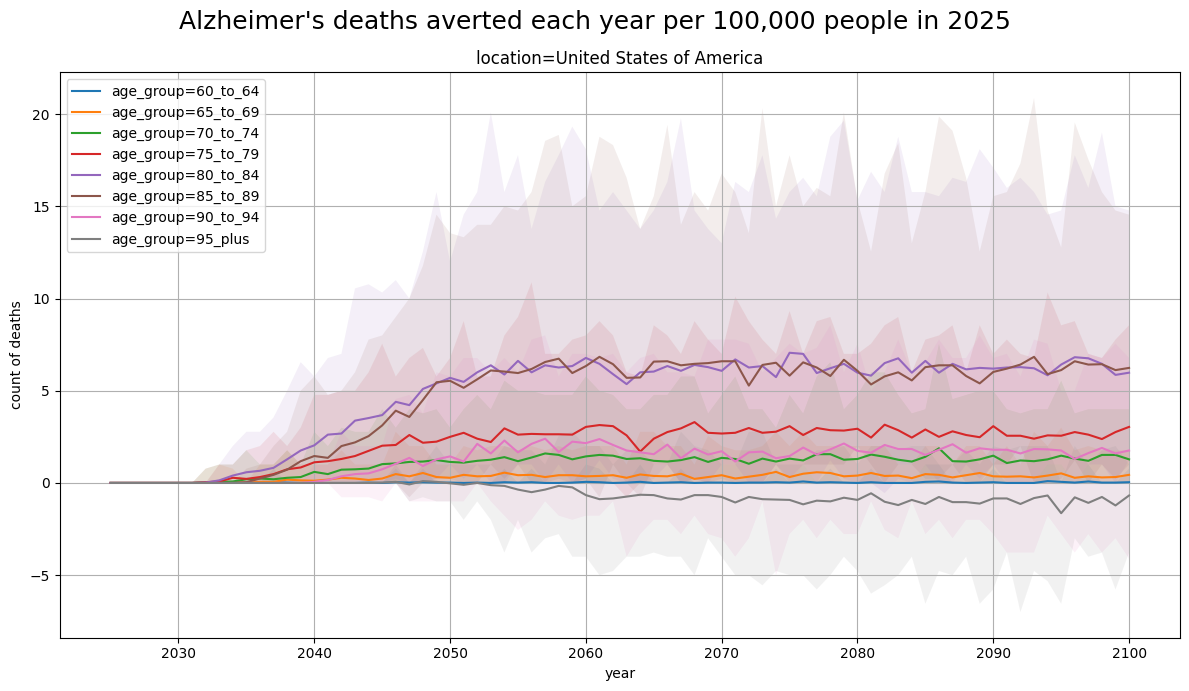

In [108]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="count of deaths",
    suptitle=f"Alzheimer's deaths averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Percent reductions in deaths for all countries

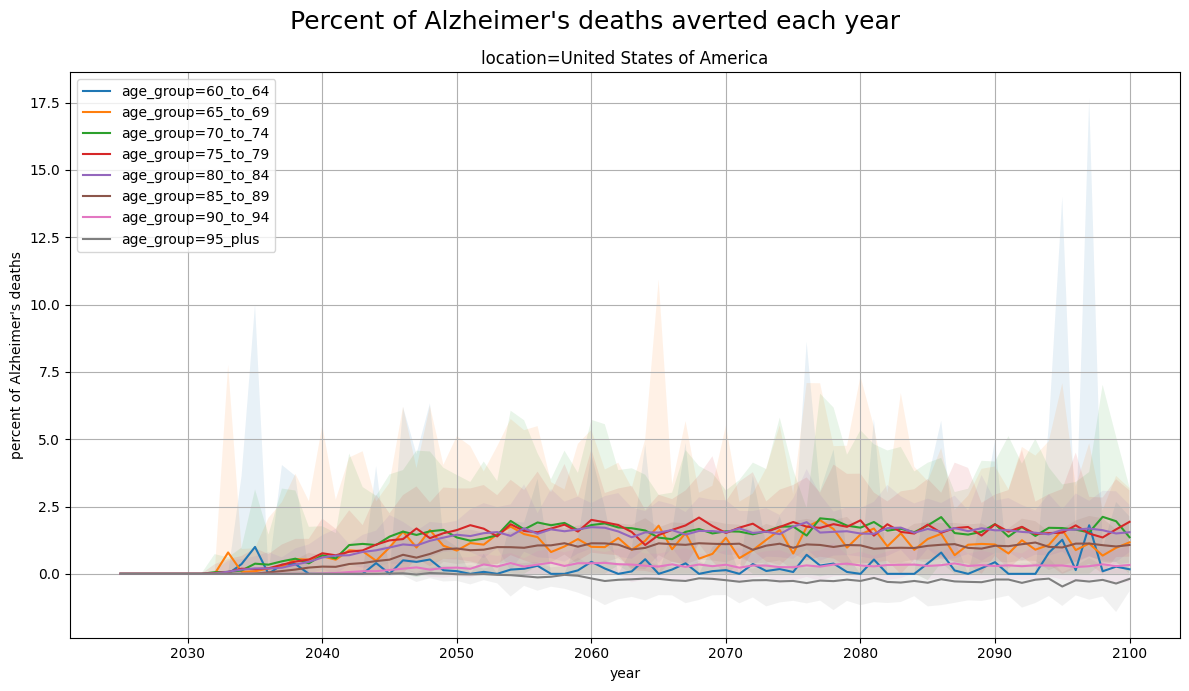

In [109]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths_pct
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="percent of Alzheimer's deaths",
    suptitle=f"Percent of Alzheimer's deaths averted each year"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Load YLLs and plot averted YLLs

In [110]:
ylls = load_sim_output('ylls')
print_memory_usage(ylls)
ylls

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf'])


4.336822 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
227995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
227996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
227997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
227998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
227999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                          entity entity_type  event_year input_draw measure  \
0       alzheimers_disease_state       cause        2025        346    ylls   
1       alzheimers_disease_state       cause        2025        346    ylls   
2       alzheimers_disease_state       cause        2025        346    ylls   
3       alzheimers_disease_state       cause        2025        346    ylls   
4       alzheimers_disease_state       cause        2025          2    ylls   
...                          ...         ...         ...        ...     ...   
227995              other_causes       cause        2100        323    ylls   
227996              other_causes       cause        2100        158    ylls   
227997              other_causes       cause        2100        158    ylls   
227998              other_causes       cause        2100        158    ylls   
227999              other_causes       cause        2100        158    ylls   

                          scenario     sex         value  \
0                         baseline  Female      0.000000   
1                         baseline    Male      0.000000   
2       bbbm_testing_and_treatment  Female      0.000000   
3       bbbm_testing_and_treatment    Male      0.000000   
4                         baseline  Female      0.000000   
...                            ...     ...           ...   
227995  bbbm_testing_and_treatment    Male   7337.210526   
227996                    baseline  Female  14072.578906   
227997                    baseline    Male   6247.096598   
227998  bbbm_testing_and_treatment  Female  14114.288565   
227999  bbbm_testing_and_treatment    Male   6271.262268   

                        location  
0       United States of America  
1       United States of America  
2       United States of America  
3       United States of America  
4       United States of America  
...                          ...  
227995  United States of America  
227996  United States of America  
227997  United States of America  
227998  United States of America  
227999  United States of America  

[228000 rows x 11 columns]

In [111]:
averted_ylls = ops.averted(ylls, baseline_scenario='baseline')
print_memory_usage(averted_ylls)

4.336822 MB measure
3.08269 MB minuend
3.08269 MB subtrahend
2.059977 MB minuend re-indexed
2.059977 MB subtrahend re-indexed
2.060037 MB difference
2.854822 MB difference with reset index
2.969147 MB final difference
2.969147 MB


In [112]:
averted_ylls.entity.unique()

['alzheimers_disease_state', 'other_causes']
Categories (2, object): ['alzheimers_disease_state', 'other_causes']

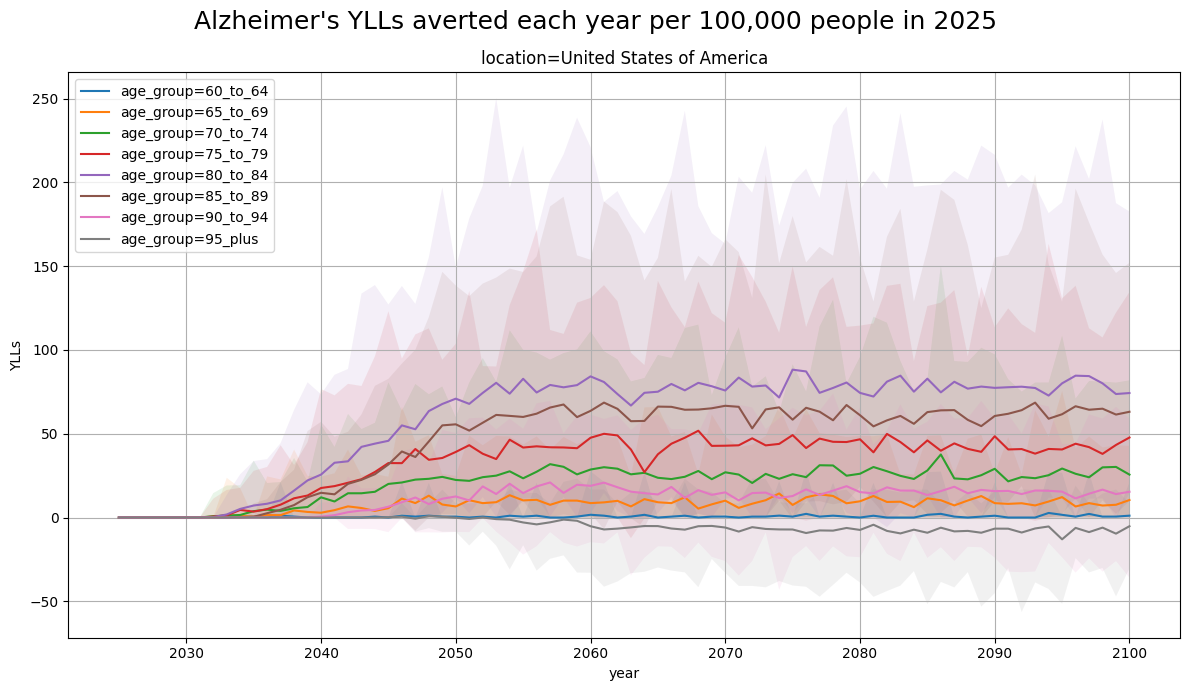

In [113]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="YLLs",
    suptitle=f"Alzheimer's YLLs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    ax.grid(True)
plt.show()

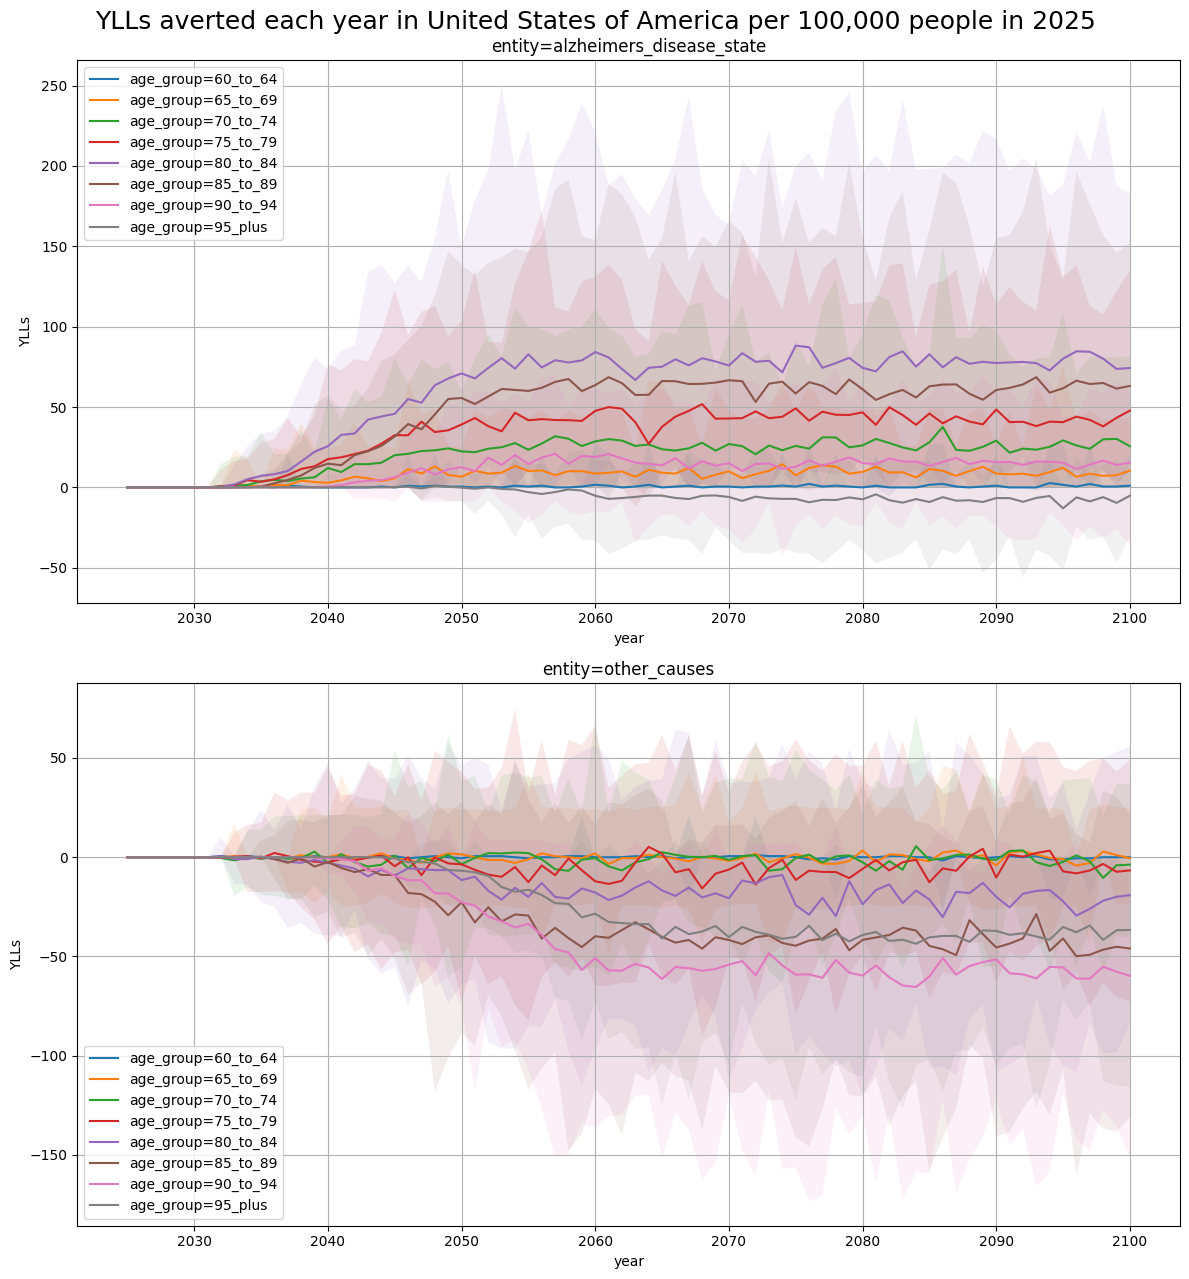

In [114]:
location = locations[0]
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and location==@location"
        ),
    'age_group',
    'entity',
    ylabel="YLLs",
    suptitle=f"YLLs averted each year in {location} per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

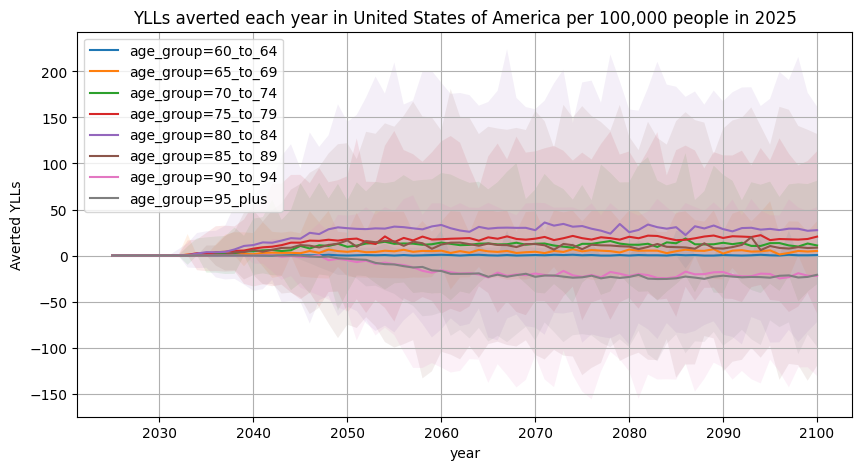

In [115]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment'" #and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="Averted YLLs",
    title=f"YLLs averted each year in {locations[0]} per 100,000 people in 2025"
)
# ax.set_xticks(ax.get_xticks()[::10])
ax.grid(True)
plt.show()

# Load YLDs and plot averted YLDs

In [116]:
ylds = load_sim_output('ylds')
print_memory_usage(ylds)
ylds

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf'])
27.366153 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
1367995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1367996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1367997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1367998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1367999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
0        alzheimers_disease_and_other_dementias       cause        2025   
1        alzheimers_disease_and_other_dementias       cause        2025   
2        alzheimers_disease_and_other_dementias       cause        2025   
3        alzheimers_disease_and_other_dementias       cause        2025   
4        alzheimers_disease_and_other_dementias       cause        2025   
...                                         ...         ...         ...   
1367995                              all_causes       cause        2100   
1367996                              all_causes       cause        2100   
1367997                              all_causes       cause        2100   
1367998                              all_causes       cause        2100   
1367999                              all_causes       cause        2100   

        input_draw measure                    scenario     sex  \
0              346    ylds                    baseline  Female   
1              346    ylds                    baseline  Female   
2              346    ylds                    baseline  Female   
3              346    ylds                    baseline    Male   
4              346    ylds                    baseline    Male   
...            ...     ...                         ...     ...   
1367995        323    ylds  bbbm_testing_and_treatment    Male   
1367996        158    ylds                    baseline  Female   
1367997        158    ylds                    baseline    Male   
1367998        158    ylds  bbbm_testing_and_treatment  Female   
1367999        158    ylds  bbbm_testing_and_treatment    Male   

                                         sub_entity        value  \
0            alzheimers_blood_based_biomarker_state     0.000000   
1        alzheimers_mild_cognitive_impairment_state     0.000000   
2                          alzheimers_disease_state     0.000000   
3            alzheimers_blood_based_biomarker_state     0.000000   
4        alzheimers_mild_cognitive_impairment_state     0.000000   
...                                             ...          ...   
1367995                                  all_causes   951.719164   
1367996                                  all_causes  1268.166604   
1367997                                  all_causes   515.299913   
1367998                                  all_causes  1268.360227   
1367999                                  all_causes   515.044554   

                         location  
0        United States of America  
1        United States of America  
2        United States of America  
3        United States of America  
4        United States of America  
...                           ...  
1367995  United States of America  
1367996  United States of America  
1367997  United States of America  
1367998  United States of America  
1367999  United States of America  

[1368000 rows x 12 columns]

In [117]:
averted_ylds = ops.averted(ylds, baseline_scenario='baseline')
print_memory_usage(averted_ylds)
# This converts years from int64 to int16
# convert_dtypes(averted_ylds, colname_to_dtype, inplace=True)
averted_ylds = averted_ylds.astype(colname_to_dtype, copy=False)
print_memory_usage(averted_ylds)
# This would convert integer years to Categorical
# convert_to_categorical(averted_ylds, inplace=True)
# print_memory_usage(averted_ylds)

27.366153 MB measure
19.158021 MB minuend
19.158021 MB subtrahend
13.00538 MB minuend re-indexed
13.00538 MB subtrahend re-indexed
13.00544 MB difference
17.790153 MB difference with reset index
18.474478 MB final difference
18.474478 MB
14.370478 MB


In [118]:
1086.443257 / 27.372526

39.69101196579373

In [119]:
averted_ylds.memory_usage(deep=True)

Index                  132
age_group           685530
artifact_path       684276
entity              684336
entity_type         684170
event_year         1368000
input_draw          684756
measure             684169
sex                 684232
sub_entity          685253
location            684974
scenario            684325
subtracted_from     684325
value              5472000
dtype: int64

In [120]:
averted_ylds.dtypes

age_group          category
artifact_path      category
entity             category
entity_type        category
event_year            int16
input_draw         category
measure            category
sex                category
sub_entity         category
location           category
scenario           category
subtracted_from    category
value               float64
dtype: object

In [121]:
averted_ylds

age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
683995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
683996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
683997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
683998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
683999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                        entity entity_type  event_year  \
0       alzheimers_disease_and_other_dementias       cause        2025   
1       alzheimers_disease_and_other_dementias       cause        2025   
2       alzheimers_disease_and_other_dementias       cause        2025   
3       alzheimers_disease_and_other_dementias       cause        2025   
4       alzheimers_disease_and_other_dementias       cause        2025   
...                                        ...         ...         ...   
683995                              all_causes       cause        2100   
683996                              all_causes       cause        2100   
683997                              all_causes       cause        2100   
683998                              all_causes       cause        2100   
683999                              all_causes       cause        2100   

       input_draw measure     sex                                  sub_entity  \
0             346    ylds  Female      alzheimers_blood_based_biomarker_state   
1             346    ylds  Female  alzheimers_mild_cognitive_impairment_state   
2             346    ylds  Female                    alzheimers_disease_state   
3             346    ylds    Male      alzheimers_blood_based_biomarker_state   
4             346    ylds    Male  alzheimers_mild_cognitive_impairment_state   
...           ...     ...     ...                                         ...   
683995        199    ylds    Male                                  all_causes   
683996        323    ylds  Female                                  all_causes   
683997        323    ylds    Male                                  all_causes   
683998        158    ylds  Female                                  all_causes   
683999        158    ylds    Male                                  all_causes   

                        location                    scenario subtracted_from  \
0       United States of America  bbbm_testing_and_treatment        baseline   
1       United States of America  bbbm_testing_and_treatment        baseline   
2       United States of America  bbbm_testing_and_treatment        baseline   
3       United States of America  bbbm_testing_and_treatment        baseline   
4       United States of America  bbbm_testing_and_treatment        baseline   
...                          ...                         ...             ...   
683995  United States of America  bbbm_testing_and_treatment        baseline   
683996  United States of America  bbbm_testing_and_treatment        baseline   
683997  United States of America  bbbm_testing_and_treatment        baseline   
683998  United States of America  bbbm_testing_and_treatment        baseline   
683999  United States of America  bbbm_testing_and_treatment        baseline   

           value  
0       0.000000  
1       0.000000  
2       0.000000  
3       0.000000  
4       0.000000  
...          ...  
683995 -0.091359  
683996  2.171356  
683997  0.536562  
683998 -0.193623  
683999  0.255360  

[684000 rows x 13 columns]

In [122]:
averted_ylds.entity.unique()

['alzheimers_disease_and_other_dementias', 'treatment', 'all_causes']
Categories (3, object): ['all_causes', 'alzheimers_disease_and_other_dementias', 'treatment']

In [123]:
# All values are 0 in this sub-dataframe
averted_ylds.query("entity=='treatment'")

age_group                                      artifact_path  \
11400   25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
11401   25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
11402   25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
11403   25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
11404   25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
680195   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
680196   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
680197   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
680198   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
680199   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

           entity entity_type  event_year input_draw measure     sex  \
11400   treatment       cause        2025        346    ylds  Female   
11401   treatment       cause        2025        346    ylds  Female   
11402   treatment       cause        2025        346    ylds  Female   
11403   treatment       cause        2025        346    ylds  Female   
11404   treatment       cause        2025        346    ylds  Female   
...           ...         ...         ...        ...     ...     ...   
680195  treatment       cause        2100        158    ylds    Male   
680196  treatment       cause        2100        158    ylds    Male   
680197  treatment       cause        2100        158    ylds    Male   
680198  treatment       cause        2100        158    ylds    Male   
680199  treatment       cause        2100        158    ylds    Male   

                     sub_entity                  location  \
11400     waiting_for_treatment  United States of America   
11401          full_effect_long  United States of America   
11402         full_effect_short  United States of America   
11403        waning_effect_long  United States of America   
11404       waning_effect_short  United States of America   
...                         ...                       ...   
680195       waning_effect_long  United States of America   
680196      waning_effect_short  United States of America   
680197     no_effect_after_long  United States of America   
680198    no_effect_after_short  United States of America   
680199  no_effect_never_treated  United States of America   

                          scenario subtracted_from  value  
11400   bbbm_testing_and_treatment        baseline    0.0  
11401   bbbm_testing_and_treatment        baseline    0.0  
11402   bbbm_testing_and_treatment        baseline    0.0  
11403   bbbm_testing_and_treatment        baseline    0.0  
11404   bbbm_testing_and_treatment        baseline    0.0  
...                            ...             ...    ...  
680195  bbbm_testing_and_treatment        baseline    0.0  
680196  bbbm_testing_and_treatment        baseline    0.0  
680197  bbbm_testing_and_treatment        baseline    0.0  
680198  bbbm_testing_and_treatment        baseline    0.0  
680199  bbbm_testing_and_treatment        baseline    0.0  

[456000 rows x 13 columns]

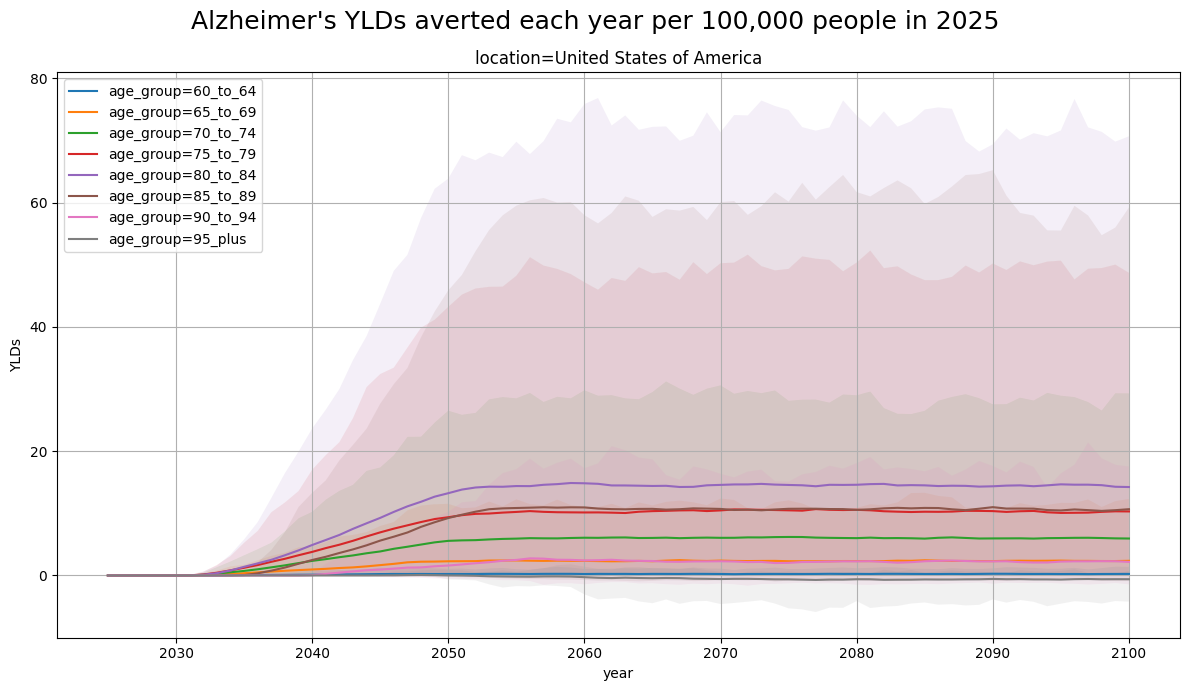

In [124]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylds
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_and_other_dementias'"
        ),
    'age_group',
    'location',
    ylabel="YLDs",
    suptitle=f"Alzheimer's YLDs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

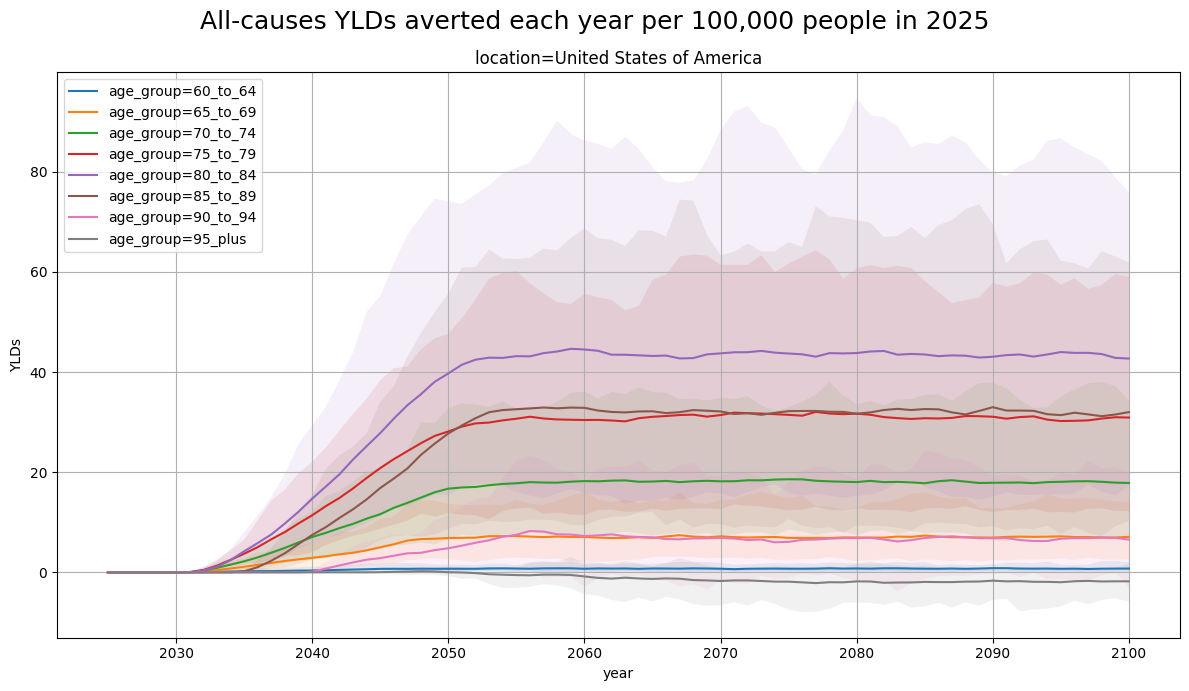

In [125]:
# I'm not sure why total YLDs averted is greater than Alzheimer's YLDs
# averted...
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylds
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'all_causes'"
        ),
    'age_group',
    'location',
    ylabel="YLDs",
    suptitle=f"All-causes YLDs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

In [126]:
# Print current time to easily check if notebook ran all the way through
# vs. hitting an error somewhere above
import datetime
print(datetime.datetime.now())

2025-10-27 17:07:20.408113
